In [1]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns

from datetime import timedelta  

%matplotlib inline


# Discrete data + probability
### Use basic probability to identify anomalous request methods. You will want to make sure the text is normalized in order to reduce the noise.

In [2]:
colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']
df_orig = pd.read_csv('http://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8]
)

new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

df = df_orig.append(new)

In [3]:
df.head()

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [4]:
df.timestamp = df.timestamp.str.replace(r'\[|\]', '')

In [5]:
df.timestamp= pd.to_datetime(df.timestamp.str.replace(':', ' ', 1)) 

In [6]:
df.head()

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,2019-04-16 19:34:42,"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,2019-04-16 19:34:42,"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,2019-04-16 19:34:44,"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
3,97.105.19.58,2019-04-16 19:34:46,"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
4,97.105.19.58,2019-04-16 19:34:48,"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [7]:
for col in ['request_method', 'request_agent', 'destination']:
    df[col] = df[col].str.replace('"', '')

In [8]:
df.head()

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,2019-04-16 19:34:42,GET /api/v1/sales?page=81 HTTP/1.1,200,512495,NaN,python-requests/2.21.0
1,97.105.19.58,2019-04-16 19:34:42,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0
2,97.105.19.58,2019-04-16 19:34:44,GET /api/v1/sales?page=82 HTTP/1.1,200,510103,NaN,python-requests/2.21.0
3,97.105.19.58,2019-04-16 19:34:46,GET /api/v1/sales?page=83 HTTP/1.1,200,510003,NaN,python-requests/2.21.0
4,97.105.19.58,2019-04-16 19:34:48,GET /api/v1/sales?page=84 HTTP/1.1,200,511963,NaN,python-requests/2.21.0


In [9]:
df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex=True)

In [10]:
df.head(10)

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,2019-04-16 19:34:42,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0
1,97.105.19.58,2019-04-16 19:34:42,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0
2,97.105.19.58,2019-04-16 19:34:44,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0
3,97.105.19.58,2019-04-16 19:34:46,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0
4,97.105.19.58,2019-04-16 19:34:48,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0
5,97.105.19.58,2019-04-16 19:34:48,GET /api/v1/stores HTTP/1.1,200,1328,NaN,python-requests/2.21.0
6,97.105.19.58,2019-04-16 19:34:50,GET /api/v1/sales HTTP/1.1,200,510753,NaN,python-requests/2.21.0
7,97.105.19.58,2019-04-16 19:34:52,GET /api/v1/sales HTTP/1.1,200,510348,NaN,python-requests/2.21.0
8,97.105.19.58,2019-04-16 19:34:52,GET / HTTP/1.1,200,42,NaN,python-requests/2.21.0
9,97.105.19.58,2019-04-16 19:34:53,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0


In [11]:
df['size_mb'] = [n/1024/1024 for n in df['size']]

In [12]:
df.describe()

,status,size,size_mb
count,13978.000000,1.397800e+04,13978.000000
mean,200.356703,4.500019e+05,0.429155
std,10.182001,1.614915e+05,0.154010
min,200.000000,0.000000e+00,0.000000
25%,200.000000,5.006370e+05,0.477445
50%,200.000000,5.101380e+05,0.486506
75%,200.000000,5.112910e+05,0.487605
max,499.000000,2.056327e+06,1.961066


## Basic Probabilities

### Using request agent

In [13]:
agent_df = pd.DataFrame(df.request_agent.value_counts(dropna=False)).reset_index().\
                rename(index=str, columns={'index': 'request_agent', 'request_agent': 'agent_count'})

In [14]:
agent_df

,request_agent,agent_count
0,python-requests/2.21.0,12005
1,python-requests/2.20.1,1911
2,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,34
3,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,8
4,Slackbot-LinkExpanding 1.0 (+https://api.slack...,7
5,Slackbot 1.0 (+https://api.slack.com/robots),6
6,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,4
7,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,2
8,Python-urllib/3.7,1


In [15]:
agent_df2 = pd.DataFrame(df.request_agent.value_counts(dropna=False)/df.request_agent.count()).reset_index().\
                rename(index=str, columns={'index': 'request_agent', 'request_agent': 'prob_agent'})

In [16]:
agent_df2

,request_agent,prob_agent
0,python-requests/2.21.0,0.858850
1,python-requests/2.20.1,0.136715
2,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,0.002432
3,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,0.000572
4,Slackbot-LinkExpanding 1.0 (+https://api.slack...,0.000501
5,Slackbot 1.0 (+https://api.slack.com/robots),0.000429
6,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,0.000286
7,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,0.000143
8,Python-urllib/3.7,0.000072


In [17]:
agent_df = agent_df.merge(agent_df2, on='request_agent')

In [18]:
agent_df

,request_agent,agent_count,prob_agent
0,python-requests/2.21.0,12005,0.858850
1,python-requests/2.20.1,1911,0.136715
2,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,34,0.002432
3,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,8,0.000572
4,Slackbot-LinkExpanding 1.0 (+https://api.slack...,7,0.000501
5,Slackbot 1.0 (+https://api.slack.com/robots),6,0.000429
6,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,4,0.000286
7,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,2,0.000143
8,Python-urllib/3.7,1,0.000072


In [19]:
agent_df[agent_df.prob_agent < .01]


,request_agent,agent_count,prob_agent
2,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,34,0.002432
3,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,8,0.000572
4,Slackbot-LinkExpanding 1.0 (+https://api.slack...,7,0.000501
5,Slackbot 1.0 (+https://api.slack.com/robots),6,0.000429
6,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,4,0.000286
7,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,2,0.000143
8,Python-urllib/3.7,1,0.000072


### Using IP address

In [20]:
ip_df = pd.DataFrame(df.ip.value_counts(dropna=False)).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_count'})

In [21]:
ip_df2 = pd.DataFrame(df.ip.value_counts(dropna=False)/df.ip.count()).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_proba'})

In [22]:
ip_df = ip_df.merge(ip_df2)


In [23]:
ip_df[ip_df.ip_proba < .01]


,ip,ip_count,ip_proba
4,68.201.219.223,21,0.001502
5,24.26.242.9,21,0.001502
6,35.175.171.137,2,0.000143
7,52.87.230.102,2,0.000143
8,70.121.214.34,2,0.000143
9,95.31.16.121,1,0.000072
10,45.23.250.16,1,0.000072
11,3.88.129.158,1,0.000072
12,34.229.70.250,1,0.000072
13,35.174.209.2,1,0.000072


22
               ip  ip_count  ip_proba
12  34.229.70.250         1  0.000072
13   35.174.209.2         1  0.000072
14  54.145.52.184         1  0.000072
15   95.31.18.119         1  0.000072
16   3.92.201.136         1  0.000072
17  52.90.165.200         1  0.000072
18   52.91.30.150         1  0.000072
19  54.172.14.223         1  0.000072
20  34.207.64.242         1  0.000072
21  97.105.15.120         1  0.000072


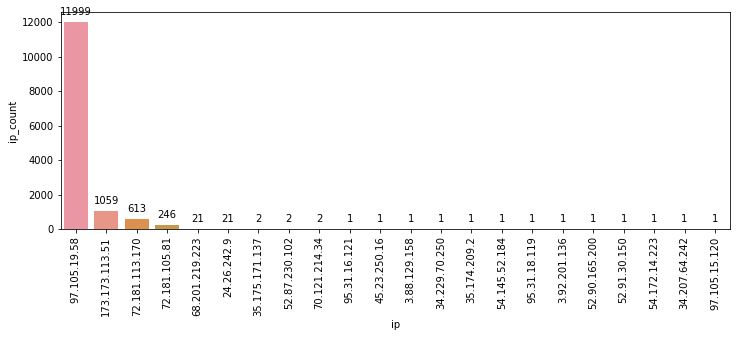

In [24]:
print(len(ip_df))

print(ip_df.tail(10))

plt.figure(figsize=(12, 4))
splot = sns.barplot(data=ip_df, x = 'ip', y = 'ip_count', ci = None)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), 
                   textcoords = 'offset points'
                   )
    plt.xticks(rotation='vertical')

## Establish a baseline

In [25]:
df.dtypes

ip                        object
timestamp         datetime64[ns]
request_method            object
status                     int64
size                       int64
destination               object
request_agent             object
size_mb                  float64
dtype: object

In [26]:
df = df.set_index('timestamp')

In [27]:
df.head()

,ip,request_method,status,size,destination,request_agent,size_mb
timestamp,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0,0.488753
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0,0.003396
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0,0.486472
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0,0.486377
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0,0.488246


In [28]:
train = df['2019-04-16 19:34:42':'2019-04-17 12:55:14'][['ip','request_method','status','size','destination','request_agent','size_mb']]

In [29]:
agent_df = pd.DataFrame(train.request_agent.value_counts(dropna=False)/train.request_agent.count()).reset_index().\
                rename(index=str, columns={'index': 'request_agent', 'request_agent': 'agent_proba'})

In [30]:
agent_df

,request_agent,agent_proba
0,python-requests/2.21.0,0.858809
1,python-requests/2.20.1,0.136754
2,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,0.002433
3,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,0.000572
4,Slackbot-LinkExpanding 1.0 (+https://api.slack...,0.000501
5,Slackbot 1.0 (+https://api.slack.com/robots),0.000429
6,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,0.000286
7,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,0.000143
8,Python-urllib/3.7,0.000072


In [31]:
df = df.reset_index().merge(agent_df, on=['request_agent'], how='left').fillna(value=0).set_index('timestamp')
df.agent_proba.value_counts()

0.858809    12005
0.136754     1911
0.002433       34
0.000572        8
0.000501        7
0.000429        6
0.000286        4
0.000143        2
0.000072        1
Name: agent_proba, dtype: int64

## Conditional Probability

### Using request agent and status

In [32]:
agent_probs = train.groupby('request_agent').size().div(len(df))

status_given_agent = pd.DataFrame(train.groupby(['request_agent', 'status']).\
                               size().div(len(train)).\
                               div(agent_probs, 
                                   axis=0, 
                                   level='request_agent').\
                               reset_index().\
                               rename(index=str, 
                                      columns={0: 'proba_status_given_agent'})
                              )

In [33]:
agent_status_count = pd.DataFrame(train.groupby(['request_agent', 'status'])['request_method'].\
                                count().reset_index().\
                                rename(index=str, 
                                       columns={'request_method': 'agent_status_count'}))


agent_status = status_given_agent.merge(agent_status_count)

In [34]:
df = df.reset_index().merge(agent_status, on=['request_agent', 'status'], how='left').fillna(value=0).set_index('timestamp')

In [35]:
df.head()

,ip,request_method,status,size,destination,request_agent,size_mb,agent_proba,proba_status_given_agent,agent_status_count
timestamp,,,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,0,python-requests/2.21.0,0.488753,0.858809,0.999286,11989.0
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,0,python-requests/2.21.0,0.003396,0.858809,0.999286,11989.0
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,0,python-requests/2.21.0,0.486472,0.858809,0.999286,11989.0
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,0,python-requests/2.21.0,0.486377,0.858809,0.999286,11989.0
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,0,python-requests/2.21.0,0.488246,0.858809,0.999286,11989.0


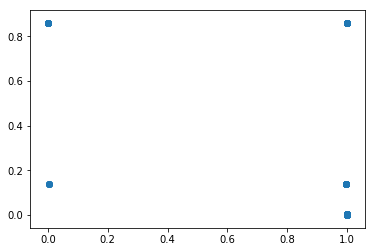

In [36]:
plt.scatter(df.proba_status_given_agent, df.agent_proba)


### Using IP address and status

In [37]:
ip_df = pd.DataFrame(train.ip.value_counts(dropna=False)/train.ip.count()).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_proba'})

In [38]:
ip_probs = train.groupby('ip').size().div(len(df))

status_given_ip = pd.DataFrame(train.groupby(['ip', 'status']).\
                               size().div(len(train)).\
                               div(ip_probs, 
                                   axis=0, 
                                   level='ip').\
                               reset_index().\
                               rename(index=str, 
                                      columns={0: 'proba_status_given_ip'})
                              )


In [39]:
ip_status_count = pd.DataFrame(train.groupby(['ip', 'status'])['request_method'].\
                                count().reset_index().\
                                rename(index=str, 
                                       columns={'request_method': 'ip_status_count'}))


ip_status = status_given_ip.merge(ip_status_count)

In [40]:
ip_df

,ip,ip_proba
0,97.105.19.58,0.858595
1,173.173.113.51,0.075784
2,72.181.113.170,0.043867
3,72.181.105.81,0.017604
4,68.201.219.223,0.001503
5,24.26.242.9,0.001503
6,35.175.171.137,0.000143
7,52.87.230.102,0.000143
8,70.121.214.34,0.000143
9,3.88.129.158,0.000072


In [41]:
df = df.reset_index().merge(ip_status, on=['ip', 'status'], how='left').fillna(value=0).set_index('timestamp')
df = df.reset_index().merge(ip_df, on=['ip'], how='left').fillna(value=0).set_index('timestamp')


In [42]:
df.head()


,ip,request_method,status,size,destination,request_agent,size_mb,agent_proba,proba_status_given_agent,agent_status_count,proba_status_given_ip,ip_status_count,ip_proba
timestamp,,,,,,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,0,python-requests/2.21.0,0.488753,0.858809,0.999286,11989.0,0.999119,11984.0,0.858595
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,0,python-requests/2.21.0,0.003396,0.858809,0.999286,11989.0,0.999119,11984.0,0.858595
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,0,python-requests/2.21.0,0.486472,0.858809,0.999286,11989.0,0.999119,11984.0,0.858595
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,0,python-requests/2.21.0,0.486377,0.858809,0.999286,11989.0,0.999119,11984.0,0.858595
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,0,python-requests/2.21.0,0.488246,0.858809,0.999286,11989.0,0.999119,11984.0,0.858595


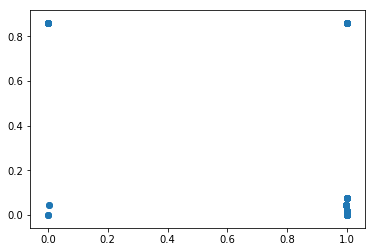

In [43]:
plt.scatter(df.proba_status_given_ip, df.ip_proba)


# Time series + EMA
## Discover users who are accessing our curriculum pages way beyond the end of their codeup time. What would the dataframe look like? Use time series method for detecting anomalies, like exponential moving average with %b.

In [416]:
import pandas as pd
import numpy as np
from datetime import datetime
import itertools

# JSON API
import requests
import json

# data visualization
import matplotlib
import seaborn as sns
import statsmodels.api as sm

%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

def evaluate(actual, predictions, output=True):
    mse = metrics.mean_squared_error(actual, predictions)
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse    

def plot_and_eval(predictions, actual, metric_fmt='{:.2f}', linewidth=4):
    if type(predictions) is not list:
        predictions = [predictions]

    plt.figure(figsize=(16, 8))
    plt.plot(train,label='Train')
    plt.plot(test, label='Test')

    for yhat in predictions:
        mse, rmse = evaluate(actual, yhat, output=False)        
        label = f'{yhat.name}'
        if len(predictions) > 1:
            label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.plot(yhat, label=label, linewidth=linewidth)

    if len(predictions) == 1:
        label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.title(label)

    plt.legend(loc='best')
    plt.show()

In [417]:
path = '~/Documents/Coding/Codeup/Coursework/ds-methodologies-exercises/anomaly/'
file = 'anonymized-curriculum-access.txt'

In [418]:
col_names = ['date', 'timestamp', 'page', 'student_id', 'cohort_id', 'ip']

In [419]:
logs = pd.read_csv(path+file, engine='python',
                 header=None,
                 index_col=False,
                 names=col_names,
                 sep= ' ',
                 na_values='"-"')

In [420]:
logs

,date,timestamp,page,student_id,cohort_id,ip
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61
5,2018-01-26,09:56:41,javascript-i/loops,2,22.0,97.105.19.61
6,2018-01-26,09:56:46,javascript-i/conditionals,3,22.0,97.105.19.61
7,2018-01-26,09:56:48,javascript-i/functions,3,22.0,97.105.19.61
8,2018-01-26,09:56:59,javascript-i/loops,2,22.0,97.105.19.61
9,2018-01-26,09:58:26,javascript-i/functions,4,22.0,97.105.19.61


In [421]:
logs['timestamp'] = logs.date+' '+logs.timestamp

In [422]:
logs = logs.drop(columns='date')

In [423]:
logs.dtypes

timestamp      object
page           object
student_id      int64
cohort_id     float64
ip             object
dtype: object

In [424]:
logs.timestamp = pd.to_datetime(logs.timestamp)

In [425]:
logs.describe()

,student_id,cohort_id
count,233528.000000,219070.000000
mean,191.155604,23.119149
std,111.150206,5.874320
min,1.000000,1.000000
25%,106.750000,22.000000
50%,202.000000,24.000000
75%,277.000000,26.000000
max,398.000000,31.000000


In [426]:
logs.set_index('timestamp', inplace=True)

In [427]:
logs.index.date

array([datetime.date(2018, 1, 26), datetime.date(2018, 1, 26),
       datetime.date(2018, 1, 26), ..., datetime.date(2019, 4, 2),
       datetime.date(2019, 4, 2), datetime.date(2019, 4, 2)], dtype=object)

In [428]:
logs.isnull().sum()

page              0
student_id        0
cohort_id     14458
ip                0
dtype: int64

In [429]:
logs.head(10)

,page,student_id,cohort_id,ip
timestamp,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61
2018-01-26 09:56:41,javascript-i/loops,2,22.0,97.105.19.61
2018-01-26 09:56:46,javascript-i/conditionals,3,22.0,97.105.19.61
2018-01-26 09:56:48,javascript-i/functions,3,22.0,97.105.19.61
2018-01-26 09:56:59,javascript-i/loops,2,22.0,97.105.19.61


# Import data from cohort dates of attendance

In [586]:
path = '~/Documents/Coding/Codeup/Coursework/ds-methodologies-exercises/anomaly/'
file = 'cohorts.txt'

In [587]:
coh_dates = pd.read_csv(path+file, engine='python',
                 header=0,
                 index_col=False,
                 sep= ',')

In [588]:
coh_dates.describe()

,id
count,31.000000
mean,16.000000
std,9.092121
min,1.000000
25%,8.500000
50%,16.000000
75%,23.500000
max,31.000000


In [589]:
coh_dates = coh_dates.rename(columns={'id': 'cohort_id'})

In [590]:
coh_dates

,cohort_id,name,start_date,end_date
0,1,Arches,2014-02-04,2014-04-22
1,2,Badlands,2014-06-04,2014-08-22
2,3,Carlsbad,2014-09-04,2014-11-05
3,4,Denali,2014-10-20,2015-01-18
4,5,Everglades,2014-11-18,2015-02-24
5,6,Franklin,2015-02-03,2015-05-26
6,7,Glacier,2015-06-05,2015-10-06
7,8,Hampton,2015-09-22,2016-02-06
8,9,Apollo,2015-03-30,2015-07-29
9,10,Balboa,2015-11-03,2016-03-11


# Merge dataframes

In [434]:
new_df = pd.merge(logs, coh_dates, on='cohort_id', how='inner', right_index=True)

In [435]:
new_df.head(10)

,page,student_id,cohort_id,ip,name,start_date,end_date
timestamp,,,,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06
2018-01-26 10:40:15,javascript-i/functions,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06
2018-01-26 11:26:13,java-i,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06
2018-01-26 11:43:17,mkdocs/search_index.json,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06
2018-01-27 07:49:25,teams/13,1,8.0,72.177.226.58,Hampton,2015-09-22,2016-02-06
2018-01-29 11:41:51,javascript-i/conditionals,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06


## Clean up some of the data

In [436]:
new_df['page'].replace(regex=r'^/$', value='home_page', inplace=True)

In [437]:
new_df.head()

,page,student_id,cohort_id,ip,name,start_date,end_date
timestamp,,,,,,,
2018-01-26 09:55:03,home_page,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06
2018-01-26 10:40:15,javascript-i/functions,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06


# How many cohorts are there? How many unique page views does each cohort have?

In [438]:
logs.cohort_id.count()

219070

In [439]:
coh_cnt = logs.groupby('cohort_id').agg(['count'])['page']
coh_cnt

,count
cohort_id,
1.0,8821
2.0,89
4.0,4
6.0,59
7.0,338
8.0,1671
9.0,5
11.0,79
12.0,230


In [440]:
coh_cnt.index

Float64Index([ 1.0,  2.0,  4.0,  6.0,  7.0,  8.0,  9.0, 11.0, 12.0, 13.0, 14.0,
              15.0, 16.0, 17.0, 18.0, 19.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0,
              27.0, 28.0, 29.0, 31.0],
             dtype='float64', name='cohort_id')

### How many null values are in cohort id?

In [441]:
logs.cohort_id.isnull().sum()

14458

# Selecting Cohort 24 ... 

In [442]:
coh24 = new_df[new_df.cohort_id == 24.0]

In [443]:
coh24.describe()

,student_id,cohort_id
count,34485.000000,34485.0
mean,196.132927,24.0
std,12.106069,0.0
min,182.000000,24.0
25%,188.000000,24.0
50%,194.000000,24.0
75%,202.000000,24.0
max,278.000000,24.0


In [444]:
coh24.isnull().sum()

page          0
student_id    0
cohort_id     0
ip            0
name          0
start_date    0
end_date      0
dtype: int64

In [445]:
coh24.index.date

array([datetime.date(2018, 5, 29), datetime.date(2018, 5, 29),
       datetime.date(2018, 5, 29), ..., datetime.date(2019, 3, 29),
       datetime.date(2019, 3, 29), datetime.date(2019, 3, 29)],
      dtype=object)

# Resample

In [446]:
coh24.resample('M').count()

,page,student_id,cohort_id,ip,name,start_date,end_date
timestamp,,,,,,,
2018-05-31,783,783,783,783,783,783,783
2018-06-30,8277,8277,8277,8277,8277,8277,8277
2018-07-31,8106,8106,8106,8106,8106,8106,8106
2018-08-31,11078,11078,11078,11078,11078,11078,11078
2018-09-30,4001,4001,4001,4001,4001,4001,4001
2018-10-31,634,634,634,634,634,634,634
2018-11-30,349,349,349,349,349,349,349
2018-12-31,375,375,375,375,375,375,375
2019-01-31,359,359,359,359,359,359,359


In [447]:
coh24.resample('W').count()

,page,student_id,cohort_id,ip,name,start_date,end_date
timestamp,,,,,,,
2018-06-03,1498,1498,1498,1498,1498,1498,1498
2018-06-10,1576,1576,1576,1576,1576,1576,1576
2018-06-17,1955,1955,1955,1955,1955,1955,1955
2018-06-24,1907,1907,1907,1907,1907,1907,1907
2018-07-01,2242,2242,2242,2242,2242,2242,2242
2018-07-08,1116,1116,1116,1116,1116,1116,1116
2018-07-15,2202,2202,2202,2202,2202,2202,2202
2018-07-22,1605,1605,1605,1605,1605,1605,1605
2018-07-29,2304,2304,2304,2304,2304,2304,2304


## Fill in missing data from resampling

In [448]:
my_datetime_fmt = mdates.DateFormatter('%m-%d %H:%T')

coh24_size = coh24['page'].resample('W').count()


In [449]:
idx2 = pd.date_range(
    coh24_size.sort_index().index.min(), 
    coh24_size.sort_index().index.max(),
    freq='W')

coh24_size = coh24_size.reindex(idx2, fill_value=0).fillna(value=0)

## Split Train / Test 

In [450]:
coh24_size.head(1)

2018-06-03    1498
Freq: W-SUN, Name: page, dtype: int64

In [451]:
start_date_train = coh24_size.head(1).index[0]
start_date_train

Timestamp('2018-06-03 00:00:00', freq='W-SUN')

In [452]:
coh24_size['2018-11-06':]

2018-11-11     87
2018-11-18     86
2018-11-25     52
2018-12-02     23
2018-12-09     42
2018-12-16     51
2018-12-23    155
2018-12-30     84
2019-01-06     85
2019-01-13     87
2019-01-20     57
2019-01-27    140
2019-02-03     38
2019-02-10     38
2019-02-17     99
2019-02-24    121
2019-03-03    101
2019-03-10     39
2019-03-17     94
2019-03-24     13
2019-03-31      8
Freq: W-SUN, Name: page, dtype: int64

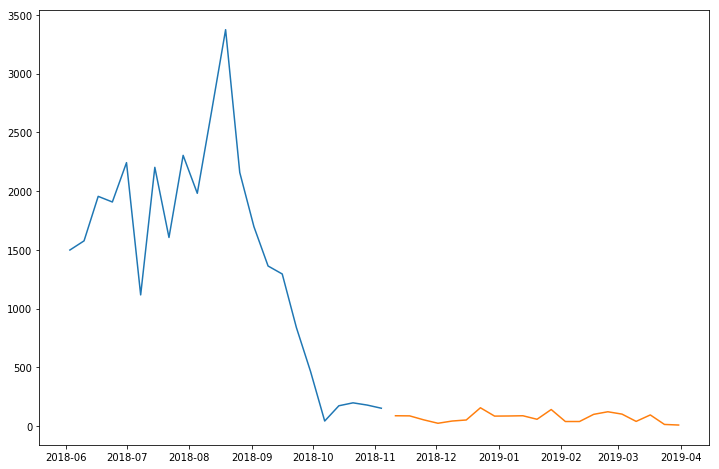

In [453]:
train = coh24_size[:'2018-11-05']
test = coh24_size['2018-11-06':]

plt.figure(figsize=(12, 8))
plt.plot(train)
plt.plot(test)
plt.show()

# SMA - Simple Moving Average


In [454]:
# Calculating the short-window simple moving average
short_rolling = train.rolling(window=2).mean()

# Calculating the long-window simple moving average
long_rolling = train.rolling(window=4).mean()

Text(0, 0.5, 'Size (MB)')

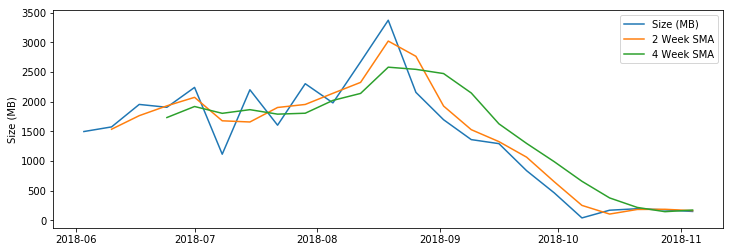

In [455]:
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(train.index, 
        train,
        label='Size (MB)')

ax.plot(short_rolling.index, 
        short_rolling, 
        label = '2 Week SMA')
ax.plot(long_rolling.index, 
        long_rolling, 
        label = '4 Week SMA')

ax.legend(loc='best')
ax.set_ylabel('Size (MB)')
# ax.xaxis.(rotate=90)
# ax.xaxis.set_major_formatter(my_datetime_fmt)

# Exponential Moving Average


In [456]:
# Using Pandas to calculate a 2 week span EMA. 
# adjust=False specifies that we are interested in the 
# recursive calculation mode.
ema_short = train.ewm(span=2, adjust=False).mean()
ema_short[0:3]

ema_long = train.ewm(span=4, adjust=False).mean()
ema_long[0:3]

2018-06-03    1498.00
2018-06-10    1529.20
2018-06-17    1699.52
Freq: W-SUN, Name: page, dtype: float64

In [457]:
ema_short[0:3]

2018-06-03    1498.0
2018-06-10    1550.0
2018-06-17    1820.0
Freq: W-SUN, Name: page, dtype: float64

In [458]:
ema_long[0:3]

2018-06-03    1498.00
2018-06-10    1529.20
2018-06-17    1699.52
Freq: W-SUN, Name: page, dtype: float64

In [459]:
span = 4
ema_long = train.ewm(span=span, adjust=False).mean()
midband = ema_long[-1]
ub = midband + ema_long[-24:-1].std()*3
lb = midband - ema_long[-24:-1].std()*3

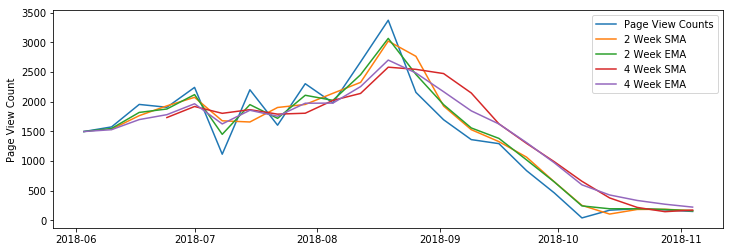

In [460]:
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(train.index, 
        train,
        label='Page View Counts')

ax.plot(short_rolling.index, 
        short_rolling, 
        label = '2 Week SMA')
ax.plot(long_rolling.index, 
        ema_short, 
        label = '2 Week EMA')
ax.plot(long_rolling.index, 
        long_rolling, 
        label = '4 Week SMA')
ax.plot(long_rolling.index, 
        ema_long, 
        label = '4 Week EMA')

ax.legend(loc='best')
ax.set_ylabel('Page View Count')

yhat = pd.DataFrame(dict(actual=test))

### Forecast using the EMA


In [461]:
span = 4
ema_long = train.ewm(span=span, adjust=False).mean()
midband = ema_long[-1]
ub = midband + ema_long[-24:-1].std()*3
lb = midband - ema_long[-24:-1].std()*3

yhat['moving_avg_forecast'] = midband

### Compute the '%b' for each record


In [462]:
# compute the absolute error:
yhat['error'] = abs(yhat.actual - yhat.moving_avg_forecast)

# compute the mean of the absolute error:
# yhat.error.median()

# compute upper band and lower band using IQR with weight of 3

yhat['pct_b'] = (yhat.actual-lb)/(ub-lb)

### Extract the anomalies


In [463]:
yhat[yhat.pct_b > 1]

,actual,moving_avg_forecast,error,pct_b


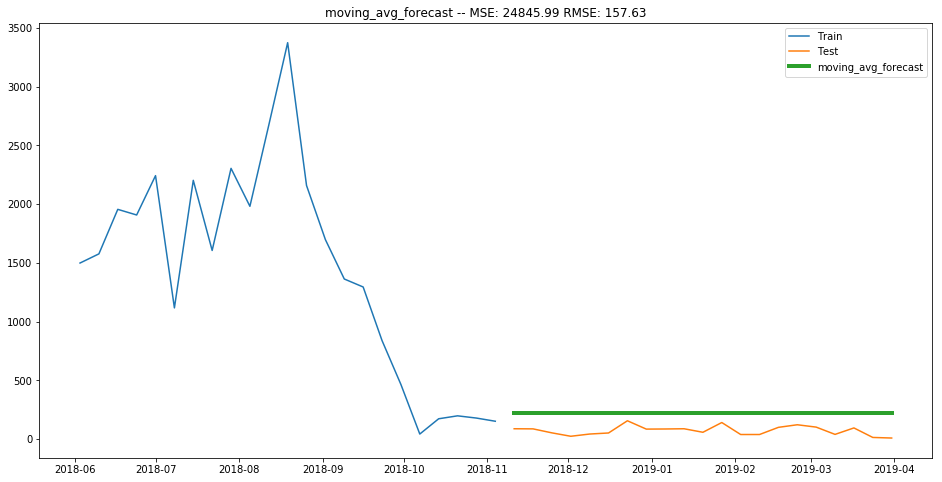

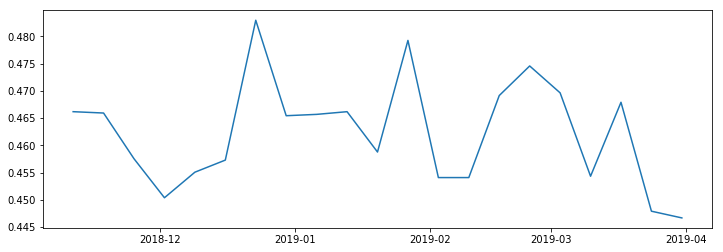

In [464]:
plot_and_eval(yhat.moving_avg_forecast, actual=test)
plt.figure(figsize=(12,4))
plt.plot(yhat.pct_b)

# Trying to automate the exploration process across all the cohorts

In [465]:
cohorts = [1.0,  2.0,  4.0,  6.0,  7.0,  8.0,  9.0, 11.0, 12.0, 13.0, 14.0,
              15.0, 16.0, 17.0, 18.0, 19.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0,
              27.0, 28.0, 29.0, 31.0]

In [466]:
cohort_dfs = []
for element in cohorts:
    element = logs[logs.cohort_id == element]
    cohort_dfs.append(element)
cohort_dfs

[                                                                  page  \
 timestamp                                                                
 2018-01-26 10:14:47                                                  /   
 2018-01-26 10:14:51                                       javascript-i   
 2018-01-26 10:15:02                             javascript-i/functions   
 2018-01-26 11:46:29  appendix/further-reading/javascript/hoisting.html   
 2018-01-26 11:46:39                                           appendix   
 2018-01-26 11:46:47       appendix/further-reading/javascript/hoisting   
 2018-01-26 11:47:01                         appendix/capstone-workbook   
 2018-01-26 11:47:03                                       javascript-i   
 2018-01-26 11:47:05                             javascript-i/functions   
 2018-01-26 12:10:30                          javascript-i/conditionals   
 2018-01-26 12:10:41                                 javascript-i/loops   
 2018-01-26 12:10:44     

In [467]:
cohort_dfs[0]

,page,student_id,cohort_id,ip
timestamp,,,,
2018-01-26 10:14:47,/,11,1.0,97.105.19.61
2018-01-26 10:14:51,javascript-i,11,1.0,97.105.19.61
2018-01-26 10:15:02,javascript-i/functions,11,1.0,97.105.19.61
2018-01-26 11:46:29,appendix/further-reading/javascript/hoisting.html,11,1.0,97.105.19.61
2018-01-26 11:46:39,appendix,11,1.0,97.105.19.61
2018-01-26 11:46:47,appendix/further-reading/javascript/hoisting,11,1.0,97.105.19.61
2018-01-26 11:47:01,appendix/capstone-workbook,11,1.0,97.105.19.61
2018-01-26 11:47:03,javascript-i,11,1.0,97.105.19.61
2018-01-26 11:47:05,javascript-i/functions,11,1.0,97.105.19.61


# Selecting Cohort 25...

In [468]:
coh25 = new_df[new_df.cohort_id == 25.0]

In [469]:
coh25.describe()

,student_id,cohort_id
count,24681.000000,24681.0
mean,232.948908,25.0
std,12.423168,0.0
min,218.000000,25.0
25%,225.000000,25.0
50%,231.000000,25.0
75%,236.000000,25.0
max,282.000000,25.0


In [470]:
coh25.isnull().sum()

page          0
student_id    0
cohort_id     0
ip            0
name          0
start_date    0
end_date      0
dtype: int64

In [471]:
coh25.head()

,page,student_id,cohort_id,ip,name,start_date,end_date
timestamp,,,,,,,
2018-07-23 13:51:26,registerUser,218,25.0,97.105.19.58,Wrangell,2018-07-23,2018-11-29
2018-07-23 13:51:39,registerUser,218,25.0,97.105.19.58,Wrangell,2018-07-23,2018-11-29
2018-07-23 15:15:19,home_page,219,25.0,97.105.19.58,Wrangell,2018-07-23,2018-11-29
2018-07-23 15:15:20,home_page,220,25.0,97.105.19.58,Wrangell,2018-07-23,2018-11-29
2018-07-23 15:15:21,home_page,221,25.0,97.105.19.58,Wrangell,2018-07-23,2018-11-29


# Resample

In [472]:
coh25.resample('M').count()

,page,student_id,cohort_id,ip,name,start_date,end_date
timestamp,,,,,,,
2018-07-31,2304,2304,2304,2304,2304,2304,2304
2018-08-31,8062,8062,8062,8062,8062,8062,8062
2018-09-30,5881,5881,5881,5881,5881,5881,5881
2018-10-31,6086,6086,6086,6086,6086,6086,6086
2018-11-30,1794,1794,1794,1794,1794,1794,1794
2018-12-31,119,119,119,119,119,119,119
2019-01-31,127,127,127,127,127,127,127
2019-02-28,259,259,259,259,259,259,259
2019-03-31,49,49,49,49,49,49,49


## Fill in missing data from resampling

In [473]:
my_datetime_fmt = mdates.DateFormatter('%m-%d %H:%T')

coh25_size = coh25['page'].resample('W').count()


In [474]:
idx3 = pd.date_range(
    coh25_size.sort_index().index.min(), 
    coh25_size.sort_index().index.max(),
    freq='W')

coh25_size = coh25_size.reindex(idx3, fill_value=0).fillna(value=0)

## Split Train / Test 

In [475]:
coh25_size.head(1)

2018-07-29    1704
Freq: W-SUN, Name: page, dtype: int64

In [476]:
start_date_train = coh25_size.head(1).index[0]
start_date_train

Timestamp('2018-07-29 00:00:00', freq='W-SUN')

In [477]:
coh25_size['2018-11-06':]

2018-11-11    765
2018-11-18    297
2018-11-25    113
2018-12-02    250
2018-12-09     78
2018-12-16     19
2018-12-23     12
2018-12-30      0
2019-01-06     71
2019-01-13      0
2019-01-20     25
2019-01-27     17
2019-02-03     16
2019-02-10     17
2019-02-17    221
2019-02-24     18
2019-03-03      1
2019-03-10     24
2019-03-17     10
2019-03-24      8
2019-03-31      7
Freq: W-SUN, Name: page, dtype: int64

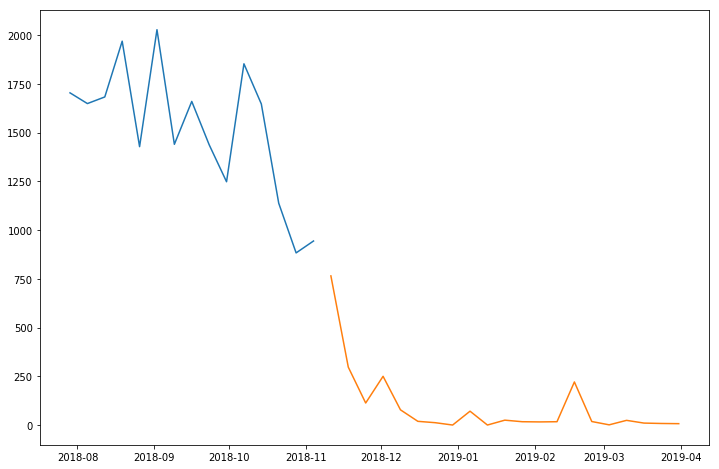

In [478]:
train2 = coh25_size[:'2018-11-05']
test2 = coh25_size['2018-11-06':]

plt.figure(figsize=(12, 8))
plt.plot(train2)
plt.plot(test2)
plt.show()

# SMA - Simple Moving Average


In [479]:
# Calculating the short-window simple moving average
short_rolling2 = train2.rolling(window=2).mean()

# Calculating the long-window simple moving average
long_rolling2 = train2.rolling(window=4).mean()

Text(0, 0.5, 'Page View Count')

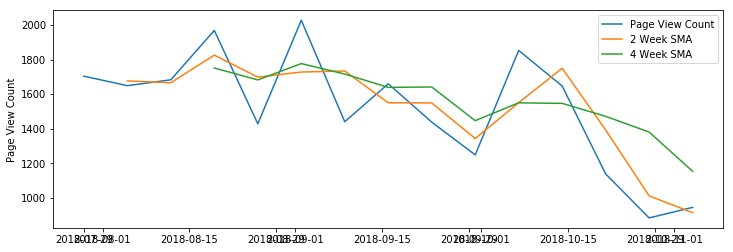

In [480]:
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(train2.index, 
        train2,
        label='Page View Count')

ax.plot(short_rolling2.index, 
        short_rolling2, 
        label = '2 Week SMA')
ax.plot(long_rolling2.index, 
        long_rolling2, 
        label = '4 Week SMA')

ax.legend(loc='best')
ax.set_ylabel('Page View Count')
# ax.xaxis.(rotate=90)
# ax.xaxis.set_major_formatter(my_datetime_fmt)

# Exponential Moving Average


In [481]:
# Using Pandas to calculate a 2 week span EMA. 
# adjust=False specifies that we are interested in the 
# recursive calculation mode.
ema_short = train2.ewm(span=2, adjust=False).mean()
ema_short[0:3]

ema_long = train2.ewm(span=4, adjust=False).mean()
ema_long[0:3]

2018-07-29    1704.0
2018-08-05    1682.0
2018-08-12    1682.4
Freq: W-SUN, Name: page, dtype: float64

In [482]:
ema_short[0:3]

2018-07-29    1704.000000
2018-08-05    1667.333333
2018-08-12    1677.777778
Freq: W-SUN, Name: page, dtype: float64

In [483]:
ema_long[0:3]

2018-07-29    1704.0
2018-08-05    1682.0
2018-08-12    1682.4
Freq: W-SUN, Name: page, dtype: float64

In [484]:
span = 4
ema_long = train2.ewm(span=span, adjust=False).mean()
midband = ema_long[-1]
ub = midband + ema_long[-24:-1].std()*3
lb = midband - ema_long[-24:-1].std()*3

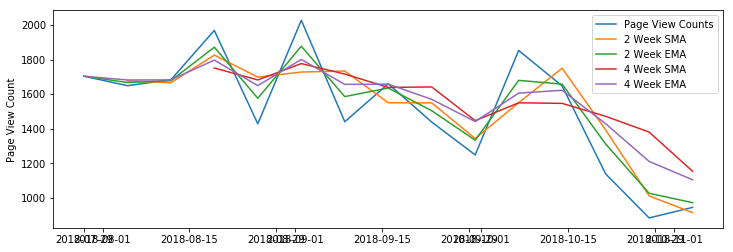

In [485]:
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(train2.index, 
        train2,
        label='Page View Counts')

ax.plot(short_rolling2.index, 
        short_rolling2, 
        label = '2 Week SMA')
ax.plot(long_rolling2.index, 
        ema_short, 
        label = '2 Week EMA')
ax.plot(long_rolling2.index, 
        long_rolling2, 
        label = '4 Week SMA')
ax.plot(long_rolling2.index, 
        ema_long, 
        label = '4 Week EMA')

ax.legend(loc='best')
ax.set_ylabel('Page View Count')

yhat = pd.DataFrame(dict(actual=test2))

### Forecast using the EMA


In [486]:
span = 4
ema_long = train2.ewm(span=span, adjust=False).mean()
midband = ema_long[-1]
ub = midband + ema_long[-24:-1].std()*3
lb = midband - ema_long[-24:-1].std()*3

yhat['moving_avg_forecast'] = midband

### Compute the '%b' for each record


In [487]:
# compute the absolute error:
yhat['error'] = abs(yhat.actual - yhat.moving_avg_forecast)

# compute the mean of the absolute error:
# yhat.error.median()

# compute upper band and lower band using IQR with weight of 3

yhat['pct_b'] = (yhat.actual-lb)/(ub-lb)

### Extract the anomalies


In [488]:
yhat[yhat.pct_b > 1]

,actual,moving_avg_forecast,error,pct_b


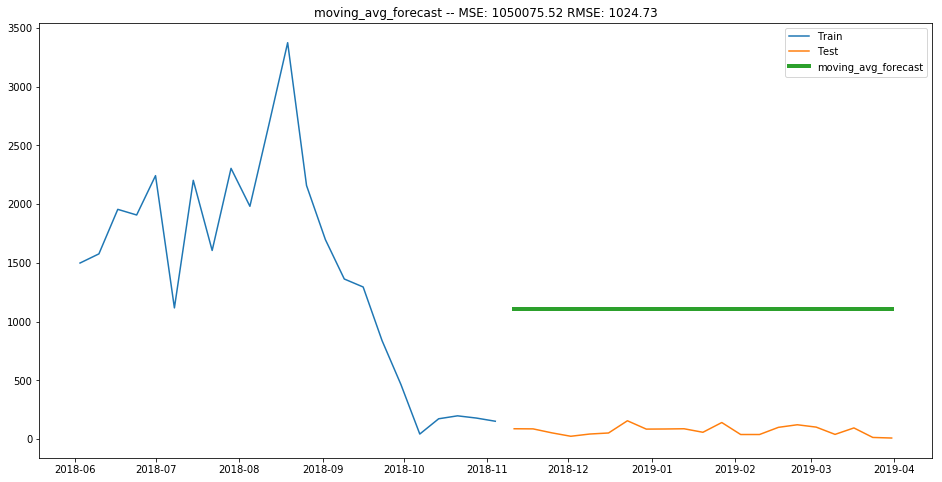

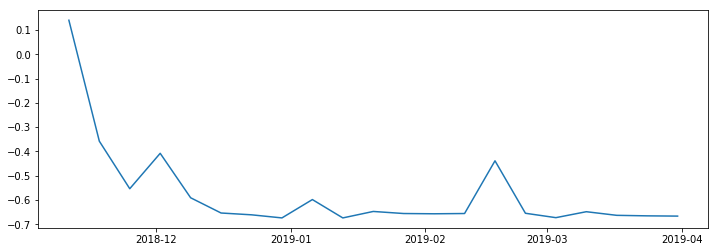

In [489]:
plot_and_eval(yhat.moving_avg_forecast, actual=test2)
plt.figure(figsize=(12,4))
plt.plot(yhat.pct_b)

## Plot the SMA and EMA with the 'fake' data that simulates usage when the cohort was in attendance (in school)

In [490]:
coh_dates[(coh_dates.cohort_id == 25)]['start_date'].values[0]

'2018-07-23'

In [491]:
coh_dates

,cohort_id,name,start_date,end_date
0,1,Arches,2014-02-04,2014-04-22
1,2,Badlands,2014-06-04,2014-08-22
2,3,Carlsbad,2014-09-04,2014-11-05
3,4,Denali,2014-10-20,2015-01-18
4,5,Everglades,2014-11-18,2015-02-24
5,6,Franklin,2015-02-03,2015-05-26
6,7,Glacier,2015-06-05,2015-10-06
7,8,Hampton,2015-09-22,2016-02-06
8,9,Apollo,2015-03-30,2015-07-29
9,10,Balboa,2015-11-03,2016-03-11


In [492]:
days = pd.date_range(start=coh_dates[(coh_dates.cohort_id == 25)]['start_date'].values[0], end=coh_dates[(coh_dates.cohort_id == 25)]['end_date'].values[0], freq='D')

np.random.seed(seed=1111)
data = np.random.randint(2400, high=2500, size=len(days))
dummy_df_coh25 = pd.DataFrame({'test': days, 'cohort25': data})
dummy_df_coh25 = dummy_df_coh25.set_index('test')
dummy_df_coh25

,cohort25
test,
2018-07-23,2428
2018-07-24,2455
2018-07-25,2481
2018-07-26,2412
2018-07-27,2434
2018-07-28,2452
2018-07-29,2424
2018-07-30,2422
2018-07-31,2420


In [493]:
dummy_df_coh25.dtypes

cohort25    int64
dtype: object

In [494]:
dummy_df_coh25 = dummy_df_coh25.reset_index()

In [495]:
dummy_df_coh25.test = pd.to_datetime(dummy_df_coh25.test)

In [496]:
dummy_df_coh25.head()

,test,cohort25
0,2018-07-23,2428
1,2018-07-24,2455
2,2018-07-25,2481
3,2018-07-26,2412
4,2018-07-27,2434


In [497]:
dummy_df_coh25 = dummy_df_coh25.set_index('test')

In [498]:
dummy_df_coh25

,cohort25
test,
2018-07-23,2428
2018-07-24,2455
2018-07-25,2481
2018-07-26,2412
2018-07-27,2434
2018-07-28,2452
2018-07-29,2424
2018-07-30,2422
2018-07-31,2420


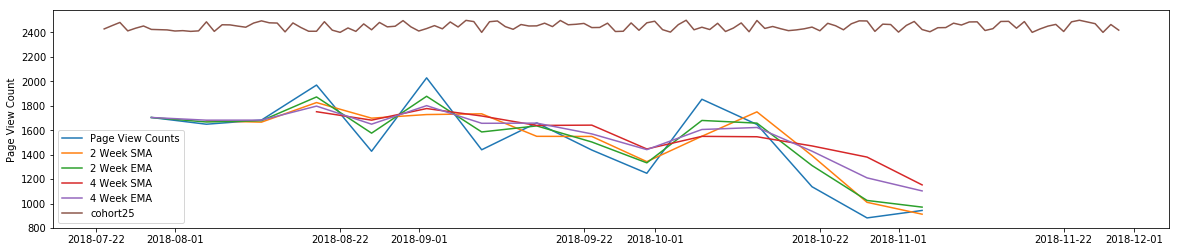

In [499]:
fig, ax = plt.subplots(figsize=(20,4))

ax.plot(train2.index, 
        train2,
        label='Page View Counts')

ax.plot(short_rolling2.index, 
        short_rolling2, 
        label = '2 Week SMA')
ax.plot(long_rolling2.index, 
        ema_short, 
        label = '2 Week EMA')
ax.plot(long_rolling2.index, 
        long_rolling2, 
        label = '4 Week SMA')
ax.plot(long_rolling2.index, 
        ema_long, 
        label = '4 Week EMA')
ax.plot(dummy_df_coh25.index,
       dummy_df_coh25.cohort25)

ax.legend(loc='best')
ax.set_ylabel('Page View Count')

yhat = pd.DataFrame(dict(actual=test))

### The goal here was to make a plot for each cohort which shows the page view counts, SMA, EMA and a dummy variable that shows hypothetical page view counts during the duration of the class attendance dates. 
### So the plots would look stacked with actual versus fake data across a timeline where data available is shown versus dates of attendance.

### The plot above shows this simulation for cohort 25. 

# Selecting Cohort 26...

In [500]:
coh26 = new_df[new_df.cohort_id == 26.0]

In [501]:
coh26.describe()

,student_id,cohort_id
count,24088.000000,24088.0
mean,269.920832,26.0
std,8.484812,0.0
min,259.000000,26.0
25%,264.000000,26.0
50%,270.000000,26.0
75%,274.000000,26.0
max,315.000000,26.0


In [502]:
coh26.isnull().sum()

page          0
student_id    0
cohort_id     0
ip            0
name          0
start_date    0
end_date      0
dtype: int64

In [503]:
coh26.head()

,page,student_id,cohort_id,ip,name,start_date,end_date
timestamp,,,,,,,
2018-09-17 14:12:28,home_page,259,26.0,97.105.19.58,Xanadu,2018-09-17,2019-02-08
2018-09-17 14:13:38,home_page,260,26.0,97.105.19.58,Xanadu,2018-09-17,2019-02-08
2018-09-17 14:13:42,html-css,260,26.0,97.105.19.58,Xanadu,2018-09-17,2019-02-08
2018-09-17 14:13:58,home_page,261,26.0,97.105.19.58,Xanadu,2018-09-17,2019-02-08
2018-09-17 14:14:21,home_page,262,26.0,97.105.19.58,Xanadu,2018-09-17,2019-02-08


# Resample

In [504]:
coh26.resample('W').count()

,page,student_id,cohort_id,ip,name,start_date,end_date
timestamp,,,,,,,
2018-09-23,1427,1427,1427,1427,1427,1427,1427
2018-09-30,1130,1130,1130,1130,1130,1130,1130
2018-10-07,1350,1350,1350,1350,1350,1350,1350
2018-10-14,1283,1283,1283,1283,1283,1283,1283
2018-10-21,1280,1280,1280,1280,1280,1280,1280
2018-10-28,1703,1703,1703,1703,1703,1703,1703
2018-11-04,1123,1123,1123,1123,1123,1123,1123
2018-11-11,1641,1641,1641,1641,1641,1641,1641
2018-11-18,915,915,915,915,915,915,915


# Selecting Cohort 27...

In [505]:
coh27 = new_df[new_df.cohort_id == 27.0]

In [506]:
coh27.describe()

,student_id,cohort_id
count,19255.000000,19255.0
mean,299.831576,27.0
std,8.216223,0.0
min,287.000000,27.0
25%,293.000000,27.0
50%,302.000000,27.0
75%,305.000000,27.0
max,371.000000,27.0


In [507]:
coh27.isnull().sum()

page          0
student_id    0
cohort_id     0
ip            0
name          0
start_date    0
end_date      0
dtype: int64

In [508]:
coh27.head()

,page,student_id,cohort_id,ip,name,start_date,end_date
timestamp,,,,,,,
2018-11-05 14:03:58,home_page,287,27.0,97.105.19.58,Yosemite,2018-11-05,2019-04-03
2018-11-05 14:04:58,home_page,288,27.0,97.105.19.58,Yosemite,2018-11-05,2019-04-03
2018-11-05 14:05:18,home_page,289,27.0,97.105.19.58,Yosemite,2018-11-05,2019-04-03
2018-11-05 14:06:41,home_page,290,27.0,97.105.19.58,Yosemite,2018-11-05,2019-04-03
2018-11-05 14:06:51,home_page,291,27.0,97.105.19.58,Yosemite,2018-11-05,2019-04-03


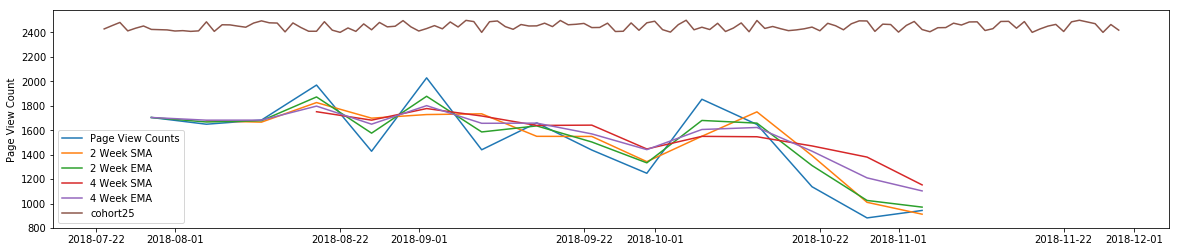

In [509]:
fig, ax = plt.subplots(figsize=(20,4))

ax.plot(train2.index, 
        train2,
        label='Page View Counts')

ax.plot(short_rolling2.index, 
        short_rolling2, 
        label = '2 Week SMA')
ax.plot(long_rolling2.index, 
        ema_short, 
        label = '2 Week EMA')
ax.plot(long_rolling2.index, 
        long_rolling2, 
        label = '4 Week SMA')
ax.plot(long_rolling2.index, 
        ema_long, 
        label = '4 Week EMA')
ax.plot(dummy_df_coh25.index,
       dummy_df_coh25.cohort25)

ax.legend(loc='best')
ax.set_ylabel('Page View Count')

yhat = pd.DataFrame(dict(actual=test))

### The goal here was to make a plot for each cohort which shows the page view counts, SMA, EMA and a dummy variable that shows hypothetical page view counts during the duration of the class attendance dates. 
### So the plots would look stacked with actual versus fake data across a timeline where data available is shown versus dates of attendance.

In [510]:
## This function makes a new dataframe based on which cohort id you pass it.

In [511]:
def make_cohort_df(n):
    n = new_df[new_df.cohort_id == n]
    return n

In [512]:
coh29 = make_cohort_df(29)

In [513]:
## This function creates some 'dummy' data that simulates site usage when the class was in session. 
## Depending on the start and end dates of each cohort.

In [514]:
def dummy_data(n):
    
    days = pd.date_range(start=coh_dates[(coh_dates.cohort_id == n)]['start_date'].values[0], end=coh_dates[(coh_dates.cohort_id == n)]['end_date'].values[0], freq='D')
    np.random.seed(seed=1111)
    data = np.random.randint(1400, high=2500, size=len(days))
    dummy_df = pd.DataFrame({'test': days, n: data})
    dummy_df = dummy_df.set_index('test')
    dummy_df = dummy_df.reset_index()
    dummy_df.test = pd.to_datetime(dummy_df.test)
    dummy_df = dummy_df.set_index('test')
    return dummy_df

In [515]:
coh29_dummy = dummy_data(29)

In [516]:
coh29_dummy

,29
test,
2019-01-22,1812
2019-01-23,1711
2019-01-24,2141
2019-01-25,2074
2019-01-26,2092
2019-01-27,1552
2019-01-28,2188
2019-01-29,1670
2019-01-30,2176


In [517]:
## This function takes the dataframe and resamples it according to an interval specified

In [518]:
def resample_df(df, interval):
    df_resample = df['page'].resample(interval).count()
    return df

In [519]:
coh29 = resample_df(coh29, 'W')

In [520]:
length = coh29.index[-1] - coh29.index[0]
length * 0.75

Timedelta('52 days 09:00:18.750000')

In [521]:
## This function splits the dataframe into a train and test dataframe based on the timestamp index length

In [522]:
def train_test_split(df):
    size = df['page'].resample('W').count()
    length = df.index[-1] - df.index[0]
    start_date_train = size.head(1).index[0]
    end_date_train = size.head(1).index[0] + (length * 0.75)
    start_date_test = size.head(1).index[0] + (length * 0.75 + timedelta(seconds=1))
    end_date_test = size.head(1).index[-1]
    train = df[:end_date_train]['cohort_id']
    test = df[start_date_test:]['cohort_id']
    return train, test

In [523]:
train_29 = train_test_split(coh29)[0]

In [524]:
test_29 = train_test_split(coh29)[1]

In [525]:
train_29

timestamp
2019-01-22 15:09:54    29.0
2019-01-22 15:10:01    29.0
2019-01-22 15:11:47    29.0
2019-01-22 15:11:53    29.0
2019-01-22 15:11:55    29.0
2019-01-22 15:11:55    29.0
2019-01-22 15:11:59    29.0
2019-01-22 15:12:00    29.0
2019-01-22 15:12:03    29.0
2019-01-22 15:12:07    29.0
2019-01-22 15:12:17    29.0
2019-01-22 15:12:28    29.0
2019-01-22 15:13:02    29.0
2019-01-22 15:13:02    29.0
2019-01-22 15:13:09    29.0
2019-01-22 15:13:10    29.0
2019-01-22 15:13:10    29.0
2019-01-22 15:13:14    29.0
2019-01-22 15:13:25    29.0
2019-01-22 15:13:36    29.0
2019-01-22 15:13:39    29.0
2019-01-22 15:13:45    29.0
2019-01-22 15:13:45    29.0
2019-01-22 15:14:00    29.0
2019-01-22 15:14:01    29.0
2019-01-22 15:14:02    29.0
2019-01-22 15:14:02    29.0
2019-01-22 15:14:05    29.0
2019-01-22 15:14:09    29.0
2019-01-22 15:14:12    29.0
                       ... 
2019-03-19 22:53:10    29.0
2019-03-19 22:53:14    29.0
2019-03-19 22:57:01    29.0
2019-03-19 23:08:51    29.0
2019-03-19

In [526]:
def make_SMA_EMA_plots(train, dummy, test):
    # Calculating the short-window simple moving average
    short_rolling2 = train.rolling(window=2).mean()

    # Calculating the long-window simple moving average
    long_rolling2 = train.rolling(window=4).mean()

    # Using Pandas to calculate a 2 week span EMA. 
    # adjust=False specifies that we are interested in the 
    # recursive calculation mode.
    ema_short = train.ewm(span=2, adjust=False).mean()
    ema_long = train.ewm(span=4, adjust=False).mean()
    span = 4
    ema_long = train.ewm(span=span, adjust=False).mean()
    midband = ema_long[-1]
    ub = midband + ema_long[-24:-1].std()*3
    lb = midband - ema_long[-24:-1].std()*3
    fig, ax = plt.subplots(figsize=(20,4))

    ax.plot(train.index, 
            train,
            label='Page View Counts')

    ax.plot(short_rolling2.index, 
            short_rolling2, 
            label = '2 Week SMA')
    ax.plot(long_rolling2.index, 
            ema_short, 
            label = '2 Week EMA')
    ax.plot(long_rolling2.index, 
            long_rolling2, 
            label = '4 Week SMA')
    ax.plot(long_rolling2.index, 
            ema_long, 
            label = '4 Week EMA')
    ax.plot(dummy.index,
           dummy.iloc[:,0])

    ax.legend(loc='best')
    ax.set_ylabel('Page View Count')

    yhat = pd.DataFrame(dict(actual=test))
    


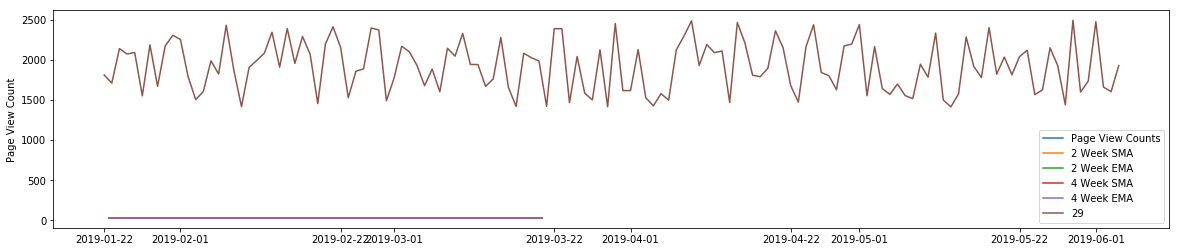

In [527]:
make_SMA_EMA_plots(train_29, coh29_dummy, test_29)

# Visualize page views per cohort over time using crosstabs

In [531]:
new_df.head()

,page,student_id,cohort_id,ip,name,start_date,end_date,date
timestamp,,,,,,,,
2018-01-26 09:55:03,home_page,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2018-01-26
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2018-01-26
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2018-01-26
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2018-01-26
2018-01-26 10:40:15,javascript-i/functions,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2018-01-26


In [532]:
new_df['date'] = new_df.index.date

In [533]:
new_df.head()

,page,student_id,cohort_id,ip,name,start_date,end_date,date
timestamp,,,,,,,,
2018-01-26 09:55:03,home_page,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2018-01-26
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2018-01-26
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2018-01-26
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2018-01-26
2018-01-26 10:40:15,javascript-i/functions,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2018-01-26


In [534]:
new_df.resample('M').sum()

,student_id,cohort_id
timestamp,,
2018-01-31,79387,62962.0
2018-02-28,395585,257786.0
2018-03-31,1255224,379381.0
2018-04-30,1140316,280165.0
2018-05-31,1241272,225120.0
2018-06-30,2554838,361636.0
2018-07-31,2566638,318767.0
2018-08-31,4272914,506548.0
2018-09-30,3097104,340106.0


In [535]:
pd.crosstab(new_df.date, new_df.name)

name,Andromeda,Apollo,Arches,Badlands,Denali,Franklin,Glacier,Hampton,Ike,Joshua,...,Quincy,Sequoia,Staff,Teddy,Ulysses,Voyageurs,Wrangell,Xanadu,Yosemite,Zion
date,,,,,,,,,,,,,,,,,,,,,
2018-01-26,0,0,19,0,0,0,0,7,0,0,...,4,173,0,323,0,0,0,0,0,0
2018-01-27,0,0,0,0,0,0,0,1,0,0,...,0,135,0,53,0,0,0,0,0,0
2018-01-28,0,0,0,0,0,0,0,0,0,0,...,0,37,0,108,0,0,0,0,0,0
2018-01-29,0,0,22,0,0,0,0,6,0,0,...,0,292,0,433,0,0,0,0,0,0
2018-01-30,0,0,12,0,0,0,0,5,0,0,...,19,139,0,349,0,0,0,0,0,0
2018-01-31,0,0,17,0,0,0,10,6,0,0,...,22,289,0,364,0,0,0,0,0,0
2018-02-01,0,0,9,0,0,0,0,11,0,0,...,21,202,0,442,0,0,0,0,0,0
2018-02-02,0,0,14,0,0,0,0,3,0,0,...,0,86,0,440,0,0,0,0,0,0
2018-02-03,0,0,0,0,0,0,0,0,0,0,...,0,75,0,148,0,0,0,0,0,0


In [536]:
pageviews = pd.crosstab(new_df.date, new_df.name)

In [537]:
pageviews.index

Index([2018-01-26, 2018-01-27, 2018-01-28, 2018-01-29, 2018-01-30, 2018-01-31,
       2018-02-01, 2018-02-02, 2018-02-03, 2018-02-04,
       ...
       2019-03-24, 2019-03-25, 2019-03-26, 2019-03-27, 2019-03-28, 2019-03-29,
       2019-03-30, 2019-03-31, 2019-04-01, 2019-04-02],
      dtype='object', name='date', length=432)

In [538]:
pd.to_datetime(pageviews.index)

DatetimeIndex(['2018-01-26', '2018-01-27', '2018-01-28', '2018-01-29',
               '2018-01-30', '2018-01-31', '2018-02-01', '2018-02-02',
               '2018-02-03', '2018-02-04',
               ...
               '2019-03-24', '2019-03-25', '2019-03-26', '2019-03-27',
               '2019-03-28', '2019-03-29', '2019-03-30', '2019-03-31',
               '2019-04-01', '2019-04-02'],
              dtype='datetime64[ns]', name='date', length=432, freq=None)

In [539]:
pageviews.index = pd.to_datetime(pageviews.index)

In [540]:
pageviews.index

DatetimeIndex(['2018-01-26', '2018-01-27', '2018-01-28', '2018-01-29',
               '2018-01-30', '2018-01-31', '2018-02-01', '2018-02-02',
               '2018-02-03', '2018-02-04',
               ...
               '2019-03-24', '2019-03-25', '2019-03-26', '2019-03-27',
               '2019-03-28', '2019-03-29', '2019-03-30', '2019-03-31',
               '2019-04-01', '2019-04-02'],
              dtype='datetime64[ns]', name='date', length=432, freq=None)

In [541]:
pageviews.resample('M').sum()

name,Andromeda,Apollo,Arches,Badlands,Denali,Franklin,Glacier,Hampton,Ike,Joshua,...,Quincy,Sequoia,Staff,Teddy,Ulysses,Voyageurs,Wrangell,Xanadu,Yosemite,Zion
date,,,,,,,,,,,,,,,,,,,,,
2018-01-31,0,0,70,0,0,0,10,25,0,0,...,45,1065,0,1630,0,0,0,0,0,0
2018-02-28,0,0,346,0,4,0,0,185,0,91,...,268,1719,0,8457,0,0,0,0,0,0
2018-03-31,0,5,1237,8,0,0,0,327,0,11,...,120,1068,0,8605,5972,0,0,0,0,0
2018-04-30,0,0,718,6,0,0,5,157,0,0,...,44,262,0,5421,5844,0,0,0,0,0
2018-05-31,0,0,845,0,0,0,96,311,3,0,...,48,651,0,1344,6260,783,0,0,0,0
2018-06-30,0,0,953,0,0,0,20,233,0,6,...,56,451,0,834,5061,8277,0,0,0,0
2018-07-31,0,0,844,0,0,0,0,167,0,5,...,53,325,0,579,1207,8106,2304,0,0,0
2018-08-31,0,0,913,0,0,0,0,170,23,10,...,55,167,0,417,398,11078,8062,0,0,0
2018-09-30,0,0,799,0,0,0,47,34,43,107,...,36,145,0,210,402,4001,5881,2557,0,0


In [542]:
pageviews.loc[:, 'Teddy':]

name,Teddy,Ulysses,Voyageurs,Wrangell,Xanadu,Yosemite,Zion
date,,,,,,,
2018-01-26,323,0,0,0,0,0,0
2018-01-27,53,0,0,0,0,0,0
2018-01-28,108,0,0,0,0,0,0
2018-01-29,433,0,0,0,0,0,0
2018-01-30,349,0,0,0,0,0,0
2018-01-31,364,0,0,0,0,0,0
2018-02-01,442,0,0,0,0,0,0
2018-02-02,440,0,0,0,0,0,0
2018-02-03,148,0,0,0,0,0,0


In [543]:
pageviews.resample('M').sum().loc[:, 'Teddy':]

name,Teddy,Ulysses,Voyageurs,Wrangell,Xanadu,Yosemite,Zion
date,,,,,,,
2018-01-31,1630,0,0,0,0,0,0
2018-02-28,8457,0,0,0,0,0,0
2018-03-31,8605,5972,0,0,0,0,0
2018-04-30,5421,5844,0,0,0,0,0
2018-05-31,1344,6260,783,0,0,0,0
2018-06-30,834,5061,8277,0,0,0,0
2018-07-31,579,1207,8106,2304,0,0,0
2018-08-31,417,398,11078,8062,0,0,0
2018-09-30,210,402,4001,5881,2557,0,0


## In class demonstration on viz. of cohorts page views

In [544]:
pageviews_by_month = pageviews.resample('M').sum().loc[:, 'Teddy':]

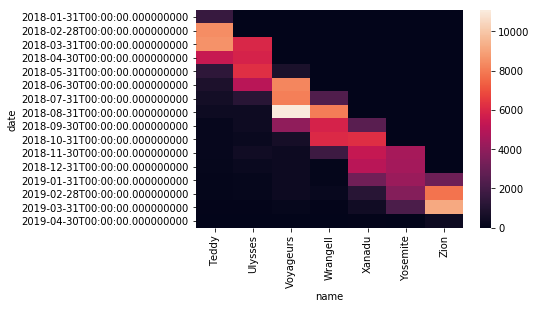

In [545]:
sns.heatmap(pageviews_by_month)

Text(0.5, 1.0, 'Pageviews By Cohort Over Time')

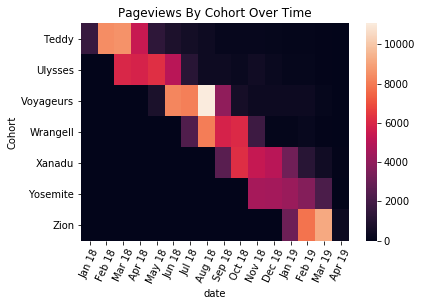

In [546]:
sns.heatmap(pageviews_by_month.T)
ticks, labels = plt.xticks()
labels = pageviews_by_month.index.strftime('%b %y')
plt.xticks(ticks, labels, rotation=65)
plt.ylabel('Cohort')
plt.title('Pageviews By Cohort Over Time')

## Working on # of distinct users accessing curriculum per cohort per day

In [547]:
new_df.isnull().sum()

page          0
student_id    0
cohort_id     0
ip            0
name          0
start_date    0
end_date      0
date          0
dtype: int64

In [548]:
df_agg = new_df.groupby(['date','cohort_id','name'])['student_id'].\
                        nunique().\
                    reset_index().\
                    rename(index=str, 
                       columns={'student_id': 'users_viewed'})

In [549]:
df_agg

,date,cohort_id,name,users_viewed
0,2018-01-26,1.0,Arches,1
1,2018-01-26,8.0,Hampton,1
2,2018-01-26,13.0,Kings,1
3,2018-01-26,16.0,Niagara,2
4,2018-01-26,18.0,Pinnacles,1
5,2018-01-26,19.0,Quincy,1
6,2018-01-26,21.0,Sequoia,16
7,2018-01-26,22.0,Teddy,26
8,2018-01-27,8.0,Hampton,1
9,2018-01-27,13.0,Kings,2


In [550]:
cohorts = list(df_agg.name.unique())
cohorts

['Arches',
 'Hampton',
 'Kings',
 'Niagara',
 'Pinnacles',
 'Quincy',
 'Sequoia',
 'Teddy',
 'Lassen',
 'Mammoth',
 'Glacier',
 'Denali',
 'Joshua',
 'Olympic',
 'Ulysses',
 'Badlands',
 'Apollo',
 'Ike',
 'Voyageurs',
 'Wrangell',
 'Xanadu',
 'Franklin',
 'Yosemite',
 'Staff',
 'Zion',
 'Andromeda']

In [551]:
new_df = df_agg.set_index('date').\
            rename(index=str, columns={'users_viewed':'ema'}).\
            drop(columns='cohort_id')

In [552]:
def bollinger_bands(df):
    ema = df.ewm(span=14, adjust=False).mean()
    ema['stdev'] = ema.ema.rolling(14).std()
    ema['ub'] = ema.ema + ema.stdev*3
    ema['lb'] = ema.ema - ema.stdev*3
    return ema.reset_index()

In [553]:
bands = []
for cohort in cohorts:
    bb = bollinger_bands(new_df[new_df.name == cohort])
    bands.append(bb)

df2 = pd.concat(bands)

In [554]:
df2.head()

,date,name,ema,stdev,ub,lb
0,2018-01-26,Arches,1.000000,NaN,NaN,NaN
1,2018-01-29,Arches,1.266667,NaN,NaN,NaN
2,2018-01-30,Arches,1.364444,NaN,NaN,NaN
3,2018-01-31,Arches,1.449185,NaN,NaN,NaN
4,2018-02-01,Arches,1.389294,NaN,NaN,NaN


In [555]:
df2.isnull().sum()


date       0
name       0
ema        0
stdev    298
ub       298
lb       298
dtype: int64

In [556]:
df_missing = df2[df2.stdev.isnull()][['name','ema']]
df_missing.head()

,name,ema
0,Arches,1.000000
1,Arches,1.266667
2,Arches,1.364444
3,Arches,1.449185
4,Arches,1.389294


In [557]:
df_missing = df_missing.groupby('name').std().fillna(value=0).reset_index().rename(index=str, columns={'ema': 'stdev_null'})
df_missing.head()

,name,stdev_null
0,Andromeda,3.418950
1,Apollo,0.000000
2,Arches,0.212673
3,Badlands,0.000000
4,Denali,0.000000


In [558]:
df = df2.merge(df_missing, on='name', how='left')


In [559]:
df.head()

,date,name,ema,stdev,ub,lb,stdev_null
0,2018-01-26,Arches,1.000000,NaN,NaN,NaN,0.212673
1,2018-01-29,Arches,1.266667,NaN,NaN,NaN,0.212673
2,2018-01-30,Arches,1.364444,NaN,NaN,NaN,0.212673
3,2018-01-31,Arches,1.449185,NaN,NaN,NaN,0.212673
4,2018-02-01,Arches,1.389294,NaN,NaN,NaN,0.212673


In [560]:
idx = df.stdev.isnull()
df.loc[idx,'stdev'] = df.loc[idx,'stdev_null']
df = df.drop(columns='stdev_null')
df.head()

,date,name,ema,stdev,ub,lb
0,2018-01-26,Arches,1.000000,0.212673,NaN,NaN
1,2018-01-29,Arches,1.266667,0.212673,NaN,NaN
2,2018-01-30,Arches,1.364444,0.212673,NaN,NaN
3,2018-01-31,Arches,1.449185,0.212673,NaN,NaN
4,2018-02-01,Arches,1.389294,0.212673,NaN,NaN


In [561]:
idx = df.ub.isnull()
df.loc[idx,'ub'] = df.loc[idx,'ema'] + df.loc[idx,'stdev']*3
df.loc[idx,'lb'] = df.loc[idx,'ema'] - df.loc[idx,'stdev']*3
df.head()

,date,name,ema,stdev,ub,lb
0,2018-01-26,Arches,1.000000,0.212673,1.638018,0.361982
1,2018-01-29,Arches,1.266667,0.212673,1.904685,0.628648
2,2018-01-30,Arches,1.364444,0.212673,2.002463,0.726426
3,2018-01-31,Arches,1.449185,0.212673,2.087204,0.811167
4,2018-02-01,Arches,1.389294,0.212673,2.027312,0.751275


In [562]:
idx = df.ub == df.lb
df.loc[idx,'ub'] = df.loc[idx,'ub'] + .01
df.loc[idx,'lb'] = df.loc[idx,'lb'] - .01

In [563]:
df.date = pd.to_datetime(df.date)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3366 entries, 0 to 3365
Data columns (total 6 columns):
date     3366 non-null datetime64[ns]
name     3366 non-null object
ema      3366 non-null float64
stdev    3366 non-null float64
ub       3366 non-null float64
lb       3366 non-null float64
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 184.1+ KB


In [564]:
df_agg.info()


<class 'pandas.core.frame.DataFrame'>
Index: 3366 entries, 0 to 3365
Data columns (total 4 columns):
date            3366 non-null object
cohort_id       3366 non-null float64
name            3366 non-null object
users_viewed    3366 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 131.5+ KB


In [566]:
df_agg.date = pd.to_datetime(df_agg.date)

In [567]:
df_agg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3366 entries, 0 to 3365
Data columns (total 4 columns):
date            3366 non-null datetime64[ns]
cohort_id       3366 non-null float64
name            3366 non-null object
users_viewed    3366 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 131.5+ KB


In [569]:
# join with aggregated dataset to get the original count of users viewed
df = df.merge(df_agg, on=['name','date'], how='left')

In [570]:
df.head()

,date,name,ema,stdev,ub,lb,cohort_id,users_viewed
0,2018-01-26,Arches,1.000000,0.212673,1.638018,0.361982,1.0,1
1,2018-01-29,Arches,1.266667,0.212673,1.904685,0.628648,1.0,3
2,2018-01-30,Arches,1.364444,0.212673,2.002463,0.726426,1.0,2
3,2018-01-31,Arches,1.449185,0.212673,2.087204,0.811167,1.0,2
4,2018-02-01,Arches,1.389294,0.212673,2.027312,0.751275,1.0,1


In [571]:
# compute %b
df['pct_b'] = (df.users_viewed-df.lb)/(df.ub-df.lb)
df = df.drop(columns=['stdev','cohort_id'])
df.head()

,date,name,ema,ub,lb,users_viewed,pct_b
0,2018-01-26,Arches,1.000000,1.638018,0.361982,1,0.500000
1,2018-01-29,Arches,1.266667,1.904685,0.628648,3,1.858372
2,2018-01-30,Arches,1.364444,2.002463,0.726426,2,0.998070
3,2018-01-31,Arches,1.449185,2.087204,0.811167,2,0.931661
4,2018-02-01,Arches,1.389294,2.027312,0.751275,1,0.194920


In [572]:
df[df.pct_b>1].sort_values(by='pct_b', ascending=False)

,date,name,ema,ub,lb,users_viewed,pct_b
2286,2018-11-05,Ulysses,1.909928,2.261775,1.558080,5,4.891207
938,2018-07-11,Quincy,1.140681,1.241638,1.039724,2,4.755855
1799,2018-11-07,Lassen,1.138224,1.239632,1.036816,2,4.749037
1730,2018-08-20,Lassen,1.137121,1.239248,1.034993,2,4.724532
595,2018-11-19,Kings,1.284884,1.488118,1.081650,3,4.719563
2023,2019-02-22,Olympic,1.135978,1.239178,1.032778,2,4.686151
1705,2018-07-19,Lassen,1.135526,1.239240,1.031812,2,4.667579
727,2018-11-21,Niagara,1.135452,1.239256,1.031648,2,4.664343
285,2018-03-01,Hampton,1.133333,1.240238,1.026429,2,4.553462
1551,2019-02-27,Teddy,1.303356,1.523545,1.083167,3,4.352699


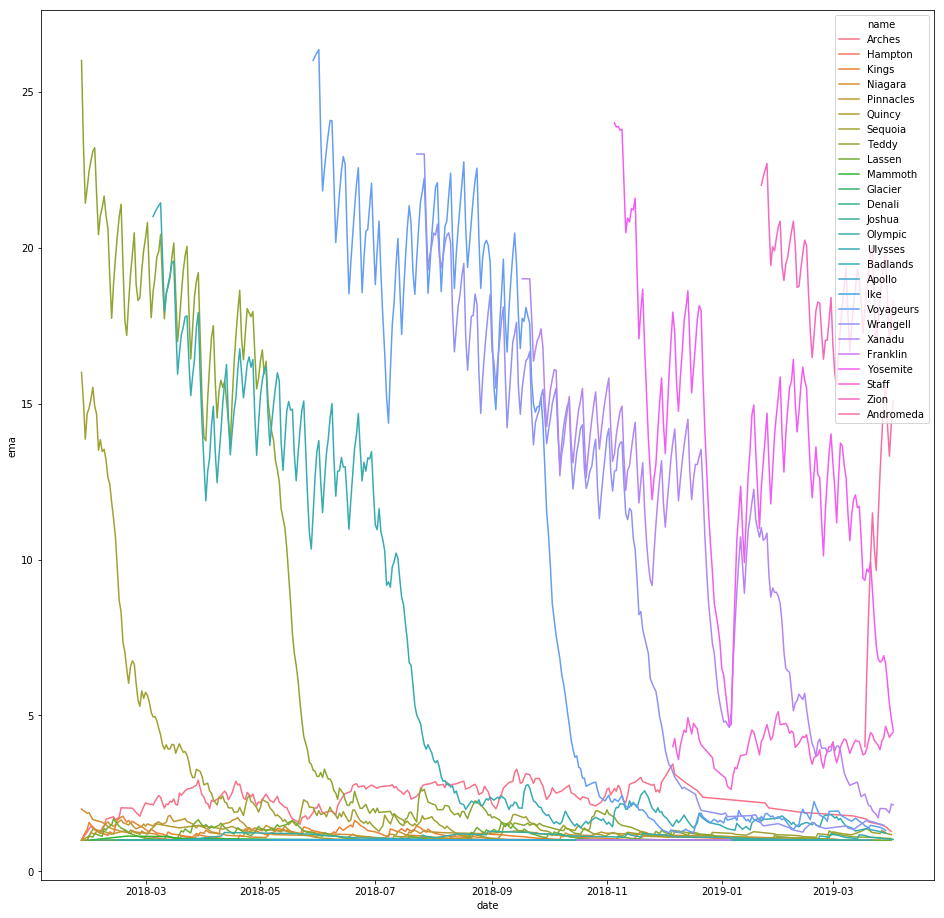

In [573]:
# plot the 7 day exponential moving average
fig = plt.figure(figsize=(16,16))
sns.lineplot(df.date, df.ema, hue=df.name)

# DBSCAN

In [591]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler


### The customers dataset

In [592]:
path = '~/Documents/Coding/Codeup/Coursework/ds-methodologies-exercises/anomaly/'
file = 'customers.csv'

In [593]:
customers = pd.read_csv(path+file, engine='python',
                 header=0,
                 index_col=False,
                 sep= ',')

In [594]:
customers.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [595]:
customers = customers.rename(str.lower, axis='columns')

In [598]:
customers.head()

,channel,region,fresh,milk,grocery,frozen,detergents_paper,delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [600]:
wk_df = customers[['frozen', 'delicassen']]

In [601]:
np_array = wk_df.values.astype("float32", copy=False)
np_array[0:10]

array([[ 214., 1338.],
       [1762., 1776.],
       [2405., 7844.],
       [6404., 1788.],
       [3915., 5185.],
       [ 666., 1451.],
       [ 480.,  545.],
       [1669., 2566.],
       [ 425.,  750.],
       [1159., 2098.]], dtype=float32)

In [602]:
stscaler = StandardScaler().fit(np_array)
np_array = stscaler.transform(np_array)
np_array[0:10]

array([[-0.5893672 , -0.06633906],
       [-0.27013618,  0.08915105],
       [-0.13753572,  2.2432926 ],
       [ 0.68714434,  0.09341105],
       [ 0.17385884,  1.2993469 ],
       [-0.49615505, -0.02622403],
       [-0.5345123 , -0.34785426],
       [-0.28931478,  0.36960125],
       [-0.54585445, -0.27507922],
       [-0.3944878 ,  0.20346113]], dtype=float32)

In [603]:
dbsc = DBSCAN(eps = 0.5, min_samples = 10).fit(np_array)

In [604]:
labels = dbsc.labels_

In [607]:
wk_df['labels'] = labels
wk_df.labels.value_counts()

 0    414
-1     26
Name: labels, dtype: int64

In [608]:
wk_df[wk_df.labels == -1].head()

,frozen,delicassen,labels
2,2405,7844,-1
22,9408,4334,-1
23,5154,16523,-1
40,9510,5864,-1
47,7782,6465,-1


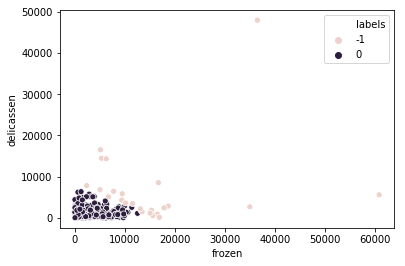

In [610]:
sns.scatterplot(wk_df.frozen, wk_df.delicassen, hue=wk_df.labels)
plt.show()

# sns.scatterplot(df.Milk, df.Fresh, hue=df.labels)
# plt.show()

# CPS Data


#### Original data: https://data.texas.gov/Social-Services/CPS-1-1-Texas-Child-Population-ages-0-17-by-County/x5xb-idr6

In [866]:
path = '~/Documents/Coding/Data/'
file = 'CPS_-_Texas_Child_Population__ages_0-17__by_County_-_FY08-_FY17.csv'

In [867]:
cps = pd.read_csv(path+file, sep= ',', header=0)

In [868]:
cps.head()

,Year,County,Region,Child Population,% of Children in Total Population,Total Population
0,2008,Anderson,4-Tyler,"11,237",19.91%,"56,445"
1,2008,Andrews,9-Midland,"3,821",27.47%,"13,908"
2,2008,Angelina,5-Beaumont,"22,131",26.64%,"83,083"
3,2008,Aransas,11-Edinburg,"5,020",19.82%,"25,327"
4,2008,Archer,2-Abilene,"2,216",23.96%,"9,248"


### Fix the names of the columns

In [869]:
cps = cps.rename(str.lower, axis='columns')

In [870]:
cps.head()

,year,county,region,child population,% of children in total population,total population
0,2008,Anderson,4-Tyler,"11,237",19.91%,"56,445"
1,2008,Andrews,9-Midland,"3,821",27.47%,"13,908"
2,2008,Angelina,5-Beaumont,"22,131",26.64%,"83,083"
3,2008,Aransas,11-Edinburg,"5,020",19.82%,"25,327"
4,2008,Archer,2-Abilene,"2,216",23.96%,"9,248"


In [871]:
cps = cps.rename(columns={'child population': 'child_pop', '% of children in total population': 'perct_children', 'total population': 'tot_pop'})

In [872]:
cps.head()

,year,county,region,child_pop,perct_children,tot_pop
0,2008,Anderson,4-Tyler,"11,237",19.91%,"56,445"
1,2008,Andrews,9-Midland,"3,821",27.47%,"13,908"
2,2008,Angelina,5-Beaumont,"22,131",26.64%,"83,083"
3,2008,Aransas,11-Edinburg,"5,020",19.82%,"25,327"
4,2008,Archer,2-Abilene,"2,216",23.96%,"9,248"


### Fix the datatypes of the columns. Change the year to a datetime and add new columns with the year. 

In [873]:
cps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2550 entries, 0 to 2549
Data columns (total 6 columns):
year              2550 non-null int64
county            2550 non-null object
region            2550 non-null object
child_pop         2550 non-null object
perct_children    2550 non-null object
tot_pop           2550 non-null object
dtypes: int64(1), object(5)
memory usage: 119.6+ KB


In [874]:
cps.year = pd.to_datetime(cps['year'].astype('str'), format='%Y')

In [875]:
cps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2550 entries, 0 to 2549
Data columns (total 6 columns):
year              2550 non-null datetime64[ns]
county            2550 non-null object
region            2550 non-null object
child_pop         2550 non-null object
perct_children    2550 non-null object
tot_pop           2550 non-null object
dtypes: datetime64[ns](1), object(5)
memory usage: 119.6+ KB


In [876]:
cps.tail()

,year,county,region,child_pop,perct_children,tot_pop
2545,2017-01-01,Yoakum,1-Lubbock,"2,701",29.92%,"9,026"
2546,2017-01-01,Young,2-Abilene,"4,617",23.7%,"19,483"
2547,2017-01-01,Zapata,11-Edinburg,"5,540",34.33%,"16,138"
2548,2017-01-01,Zavala,8-San Antonio,"3,848",30.64%,"12,560"
2549,2017-01-01,All Counties,All Regions,"7,500,272",26.05%,"28,797,290"


In [877]:
cps = cps.rename(columns={'year': 'datetime'})

In [878]:
cps.head()

,datetime,county,region,child_pop,perct_children,tot_pop
0,2008-01-01,Anderson,4-Tyler,"11,237",19.91%,"56,445"
1,2008-01-01,Andrews,9-Midland,"3,821",27.47%,"13,908"
2,2008-01-01,Angelina,5-Beaumont,"22,131",26.64%,"83,083"
3,2008-01-01,Aransas,11-Edinburg,"5,020",19.82%,"25,327"
4,2008-01-01,Archer,2-Abilene,"2,216",23.96%,"9,248"


In [879]:
cps['year'] = cps['datetime'].dt.year

In [880]:
cps.head()

,datetime,county,region,child_pop,perct_children,tot_pop,year
0,2008-01-01,Anderson,4-Tyler,"11,237",19.91%,"56,445",2008
1,2008-01-01,Andrews,9-Midland,"3,821",27.47%,"13,908",2008
2,2008-01-01,Angelina,5-Beaumont,"22,131",26.64%,"83,083",2008
3,2008-01-01,Aransas,11-Edinburg,"5,020",19.82%,"25,327",2008
4,2008-01-01,Archer,2-Abilene,"2,216",23.96%,"9,248",2008


### Change the numeric columns to int64 or float64 depending on the data.

In [881]:
cps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2550 entries, 0 to 2549
Data columns (total 7 columns):
datetime          2550 non-null datetime64[ns]
county            2550 non-null object
region            2550 non-null object
child_pop         2550 non-null object
perct_children    2550 non-null object
tot_pop           2550 non-null object
year              2550 non-null int64
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 139.5+ KB


In [882]:
cps.isnull().sum()

datetime          0
county            0
region            0
child_pop         0
perct_children    0
tot_pop           0
year              0
dtype: int64

In [883]:
cps['child_pop'] = cps['child_pop'].str.replace(',','')

In [884]:
cps.head()

,datetime,county,region,child_pop,perct_children,tot_pop,year
0,2008-01-01,Anderson,4-Tyler,11237,19.91%,"56,445",2008
1,2008-01-01,Andrews,9-Midland,3821,27.47%,"13,908",2008
2,2008-01-01,Angelina,5-Beaumont,22131,26.64%,"83,083",2008
3,2008-01-01,Aransas,11-Edinburg,5020,19.82%,"25,327",2008
4,2008-01-01,Archer,2-Abilene,2216,23.96%,"9,248",2008


In [885]:
cps['perct_children'] = cps['perct_children'].str.replace('%','')

In [886]:
cps['tot_pop'] = cps['tot_pop'].str.replace(',','')

In [887]:
cps.head()

,datetime,county,region,child_pop,perct_children,tot_pop,year
0,2008-01-01,Anderson,4-Tyler,11237,19.91,56445,2008
1,2008-01-01,Andrews,9-Midland,3821,27.47,13908,2008
2,2008-01-01,Angelina,5-Beaumont,22131,26.64,83083,2008
3,2008-01-01,Aransas,11-Edinburg,5020,19.82,25327,2008
4,2008-01-01,Archer,2-Abilene,2216,23.96,9248,2008


In [888]:
cps.child_pop = cps['child_pop'].astype('float64')

In [889]:
cps.perct_children = cps['perct_children'].astype('float64')

In [890]:
cps.tot_pop = cps['tot_pop'].astype('float64')

In [891]:
cps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2550 entries, 0 to 2549
Data columns (total 7 columns):
datetime          2550 non-null datetime64[ns]
county            2550 non-null object
region            2550 non-null object
child_pop         2550 non-null float64
perct_children    2550 non-null float64
tot_pop           2550 non-null float64
year              2550 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 139.5+ KB


### Checking for nulls

In [892]:
cps.isnull().sum()

datetime          0
county            0
region            0
child_pop         0
perct_children    0
tot_pop           0
year              0
dtype: int64

### Checking for the unique types of values in the region column

In [893]:
cps.region.value_counts()

1-Lubbock        410
7-Austin         300
2-Abilene        300
9-Midland        300
8-San Antonio    280
4-Tyler          230
3-Arlington      190
11-Edinburg      190
5-Beaumont       150
6-Houston        130
10-El Paso        60
All Regions       10
Name: region, dtype: int64

### Now that the datatypes are fixed, change the region into two separate columns that contain region id (numeric) and region name.

In [894]:
cps['region_id'] = cps.region.str.split(pat='-', n=1, expand=True)[0]

In [895]:
cps.head()

,datetime,county,region,child_pop,perct_children,tot_pop,year,region_id
0,2008-01-01,Anderson,4-Tyler,11237.0,19.91,56445.0,2008,4
1,2008-01-01,Andrews,9-Midland,3821.0,27.47,13908.0,2008,9
2,2008-01-01,Angelina,5-Beaumont,22131.0,26.64,83083.0,2008,5
3,2008-01-01,Aransas,11-Edinburg,5020.0,19.82,25327.0,2008,11
4,2008-01-01,Archer,2-Abilene,2216.0,23.96,9248.0,2008,2


In [896]:
cps.region_id.value_counts()

1              410
9              300
2              300
7              300
8              280
4              230
11             190
3              190
5              150
6              130
10              60
All Regions     10
Name: region_id, dtype: int64

In [897]:
cps.region =  cps.region.str.split(pat='-', n=1, expand=True)[1]

In [898]:
cps.head()

,datetime,county,region,child_pop,perct_children,tot_pop,year,region_id
0,2008-01-01,Anderson,Tyler,11237.0,19.91,56445.0,2008,4
1,2008-01-01,Andrews,Midland,3821.0,27.47,13908.0,2008,9
2,2008-01-01,Angelina,Beaumont,22131.0,26.64,83083.0,2008,5
3,2008-01-01,Aransas,Edinburg,5020.0,19.82,25327.0,2008,11
4,2008-01-01,Archer,Abilene,2216.0,23.96,9248.0,2008,2


In [899]:
cps.region.value_counts()

Lubbock        410
Austin         300
Midland        300
Abilene        300
San Antonio    280
Tyler          230
Arlington      190
Edinburg       190
Beaumont       150
Houston        130
El Paso         60
Name: region, dtype: int64

### Checking for nulls

In [900]:
cps.isnull().sum()

datetime           0
county             0
region            10
child_pop          0
perct_children     0
tot_pop            0
year               0
region_id          0
dtype: int64

### Fill nulls with 0 in the region column

In [901]:
cps.region = cps.region.fillna(value=0)

In [902]:
cps.isnull().sum()

datetime          0
county            0
region            0
child_pop         0
perct_children    0
tot_pop           0
year              0
region_id         0
dtype: int64

### Fix the very last entry of the dataframe, which contains the aggregate information of all the counties.

In [903]:
cps.tail(1)

,datetime,county,region,child_pop,perct_children,tot_pop,year,region_id
2549,2017-01-01,All Counties,0,7500272.0,26.05,28797290.0,2017,All Regions


In [904]:
cps.at[2549, 'region_id'] = 0

In [905]:
cps.tail(1)

,datetime,county,region,child_pop,perct_children,tot_pop,year,region_id
2549,2017-01-01,All Counties,0,7500272.0,26.05,28797290.0,2017,0


In [906]:
cps.head()

,datetime,county,region,child_pop,perct_children,tot_pop,year,region_id
0,2008-01-01,Anderson,Tyler,11237.0,19.91,56445.0,2008,4
1,2008-01-01,Andrews,Midland,3821.0,27.47,13908.0,2008,9
2,2008-01-01,Angelina,Beaumont,22131.0,26.64,83083.0,2008,5
3,2008-01-01,Aransas,Edinburg,5020.0,19.82,25327.0,2008,11
4,2008-01-01,Archer,Abilene,2216.0,23.96,9248.0,2008,2


In [907]:
cps.region_id.value_counts()

1              410
9              300
2              300
7              300
8              280
4              230
11             190
3              190
5              150
6              130
10              60
All Regions      9
0                1
Name: region_id, dtype: int64

In [908]:
cps.isnull().sum()

datetime          0
county            0
region            0
child_pop         0
perct_children    0
tot_pop           0
year              0
region_id         0
dtype: int64

In [909]:
cps.region_id.value_counts()

1              410
9              300
2              300
7              300
8              280
4              230
11             190
3              190
5              150
6              130
10              60
All Regions      9
0                1
Name: region_id, dtype: int64

### Change any region_id of 'All Regions' to ZERO

In [926]:
# cps.region_id.loc["All Regions":].str.replace(pat='All Regions', repl='0')

In [927]:
cps.loc[cps['region_id'] == "All Regions", 'region_id'] = 0

In [928]:
cps.region_id.value_counts()

1     410
9     300
2     300
7     300
8     280
4     230
11    190
3     190
5     150
6     130
10     60
0      10
Name: region_id, dtype: int64

### Change the region_id to a numeric datatype

In [929]:
cps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2550 entries, 0 to 2549
Data columns (total 8 columns):
datetime          2550 non-null datetime64[ns]
county            2550 non-null object
region            2550 non-null object
child_pop         2550 non-null float64
perct_children    2550 non-null float64
tot_pop           2550 non-null float64
year              2550 non-null int64
region_id         2550 non-null object
dtypes: datetime64[ns](1), float64(3), int64(1), object(3)
memory usage: 159.5+ KB


In [930]:
cps.region_id = cps.region_id.astype('int64')

In [931]:
cps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2550 entries, 0 to 2549
Data columns (total 8 columns):
datetime          2550 non-null datetime64[ns]
county            2550 non-null object
region            2550 non-null object
child_pop         2550 non-null float64
perct_children    2550 non-null float64
tot_pop           2550 non-null float64
year              2550 non-null int64
region_id         2550 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 159.5+ KB


In [932]:
cps.head(10)

,datetime,county,region,child_pop,perct_children,tot_pop,year,region_id
0,2008-01-01,Anderson,Tyler,11237.0,19.91,56445.0,2008,4
1,2008-01-01,Andrews,Midland,3821.0,27.47,13908.0,2008,9
2,2008-01-01,Angelina,Beaumont,22131.0,26.64,83083.0,2008,5
3,2008-01-01,Aransas,Edinburg,5020.0,19.82,25327.0,2008,11
4,2008-01-01,Archer,Abilene,2216.0,23.96,9248.0,2008,2
5,2008-01-01,Armstrong,Lubbock,502.0,22.89,2193.0,2008,1
6,2008-01-01,Atascosa,San Antonio,12615.0,28.78,43829.0,2008,8
7,2008-01-01,Austin,Houston,6705.0,24.59,27270.0,2008,6
8,2008-01-01,Bailey,Lubbock,1877.0,29.87,6283.0,2008,1
9,2008-01-01,Bandera,San Antonio,4080.0,20.08,20314.0,2008,8


In [937]:
cps.set_index('datetime', inplace=True)

In [940]:
cps.resample('Y')

DatetimeIndexResampler [freq=<YearEnd: month=12>, axis=0, closed=right, label=right, convention=start, base=0]

In [941]:
cps.head()

,county,region,child_pop,perct_children,tot_pop,year,region_id
datetime,,,,,,,
2008-01-01,Anderson,Tyler,11237.0,19.91,56445.0,2008,4
2008-01-01,Andrews,Midland,3821.0,27.47,13908.0,2008,9
2008-01-01,Angelina,Beaumont,22131.0,26.64,83083.0,2008,5
2008-01-01,Aransas,Edinburg,5020.0,19.82,25327.0,2008,11
2008-01-01,Archer,Abilene,2216.0,23.96,9248.0,2008,2


In [942]:
cps.county.value_counts()

Gonzales       10
Duval          10
Calhoun        10
Wharton        10
Eastland       10
Hartley        10
Collin         10
Ochiltree      10
Starr          10
Terry          10
Hale           10
Shackelford    10
Gillespie      10
Dimmit         10
El Paso        10
Bell           10
Baylor         10
Red River      10
Harrison       10
Bailey         10
Culberson      10
Bee            10
Hill           10
Aransas        10
Newton         10
Carson         10
Swisher        10
Mitchell       10
Lavaca         10
Cottle         10
               ..
Sabine         10
Tarrant        10
Leon           10
Martin         10
Dallas         10
Wheeler        10
Medina         10
Brooks         10
Edwards        10
Lamb           10
Knox           10
Val Verde      10
LaSalle        10
Burleson       10
Van Zandt      10
Colorado       10
Hemphill       10
Hidalgo        10
Hutchinson     10
Zavala         10
Young          10
Karnes         10
Kerr           10
Kleberg        10
Limestone 

In [944]:
len(cps.year.value_counts())

10

## There are 10 years of data. There are 254 counties in the df (all in TX). There is a row 'all counties'.

In [945]:
cps.year.value_counts()

2017    255
2015    255
2013    255
2011    255
2009    255
2016    255
2014    255
2012    255
2010    255
2008    255
Name: year, dtype: int64

In [947]:
cps.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2550 entries, 2008-01-01 to 2017-01-01
Data columns (total 7 columns):
county            2550 non-null object
region            2550 non-null object
child_pop         2550 non-null float64
perct_children    2550 non-null float64
tot_pop           2550 non-null float64
year              2550 non-null int64
region_id         2550 non-null int64
dtypes: float64(3), int64(2), object(2)
memory usage: 239.4+ KB


## Edit dataframe a bit more...
### Drop region_id and the all counties row

In [948]:
cps.head()

,county,region,child_pop,perct_children,tot_pop,year,region_id
datetime,,,,,,,
2008-01-01,Anderson,Tyler,11237.0,19.91,56445.0,2008,4
2008-01-01,Andrews,Midland,3821.0,27.47,13908.0,2008,9
2008-01-01,Angelina,Beaumont,22131.0,26.64,83083.0,2008,5
2008-01-01,Aransas,Edinburg,5020.0,19.82,25327.0,2008,11
2008-01-01,Archer,Abilene,2216.0,23.96,9248.0,2008,2


In [951]:
cps = cps.drop('region_id', axis=1)

In [952]:
cps.head()

,county,region,child_pop,perct_children,tot_pop,year
datetime,,,,,,
2008-01-01,Anderson,Tyler,11237.0,19.91,56445.0,2008
2008-01-01,Andrews,Midland,3821.0,27.47,13908.0,2008
2008-01-01,Angelina,Beaumont,22131.0,26.64,83083.0,2008
2008-01-01,Aransas,Edinburg,5020.0,19.82,25327.0,2008
2008-01-01,Archer,Abilene,2216.0,23.96,9248.0,2008


In [960]:
cps.iloc[-1,:]

county            All Counties
region                       0
child_pop          7.50027e+06
perct_children           26.05
tot_pop            2.87973e+07
year                      2017
Name: 2017-01-01 00:00:00, dtype: object

## Visualize the change of children population over time across the counties.

In [933]:
cps.groupby(['year', 'region'])

In [934]:
cps.groupby(['year', 'region']).agg('sum')

child_pop  perct_children     tot_pop  region_id
year region                                                       
2008 0            6495224.0           26.70  24326974.0          0
     Abilene       129918.0          662.08    547273.0         60
     Arlington    1787328.0          481.94   6623803.0         57
     Austin        687621.0          695.22   2815141.0        210
     Beaumont      181952.0          343.09    753854.0         75
     Edinburg      632538.0          514.22   2021188.0        209
     El Paso       223615.0          148.50    774524.0         60
     Houston      1582378.0          327.88   5859339.0         78
     Lubbock       209519.0         1030.15    815358.0         41
     Midland       142955.0          680.55    545368.0        270
     San Antonio   656179.0          701.35   2483977.0        224
     Tyler         261221.0          536.46   1087149.0         92
2009 0            6557436.0           26.46  24782302.0          0
     Abilene       130622.0          658.16    552450.0         60
     Arlington    1813205.0          477.40   6770397.0         57
     Austin        697302.0          689.33   2877349.0        210
     Beaumont      181854.0          339.95    758730.0         75
     Edinburg      633106.0          508.21   2044913.0        209
     El Paso       222485.0          146.30    781204.0         60
     Houston      1600259.0          324.54   5990432.0         78
     Lubbock       210805.0         1023.20    825458.0         41
     Midland       144760.0          673.85    555206.0        270
     San Antonio   661421.0          693.65   2529527.0        224
     Tyler         261617.0          531.61   1096636.0         92
2010 0            6865824.0           27.30  25145561.0          0
     Abilene       129373.0          694.06    550250.0         60
     Arlington    1860693.0          497.29   6733179.0         57
     Austin        739441.0          712.85   2948364.0        210
     Beaumont      184465.0          346.75    767222.0         75
     Edinburg      671080.0          516.19   2105700.0        209
...                     ...             ...         ...        ...
2015 El Paso       254926.0          145.00    900316.0         60
     Houston      1804107.0          322.51   6794658.0         78
     Lubbock       233103.0         1046.54    889179.0         41
     Midland       159694.0          704.28    607151.0        270
     San Antonio   739175.0          661.78   2868438.0        224
     Tyler         278160.0          528.95   1173560.0         92
2016 0            7407636.0           26.23  28240245.0          0
     Abilene       132137.0          662.94    568459.0         60
     Arlington    2009829.0          468.65   7596324.0         57
     Austin        850324.0          679.72   3411407.0        210
     Beaumont      190318.0          330.45    808167.0         75
     Edinburg      714490.0          494.73   2370249.0        209
     El Paso       257264.0          144.22    915995.0         60
     Houston      1828051.0          319.92   6946624.0         78
     Lubbock       235840.0         1038.63    899512.0         41
     Midland       161237.0          698.56    614031.0        270
     San Antonio   748085.0          657.04   2923361.0        224
     Tyler         280061.0          525.99   1186116.0         92
2017 0            7500272.0           26.05  28797290.0          0
     Abilene       132625.0          658.92    571340.0         60
     Arlington    2034172.0          464.13   7755244.0         57
     Austin        869065.0          676.49   3495220.0        210
     Beaumont      191504.0          328.26    815056.0         75
     Edinburg      721797.0          490.98   2416831.0        209
     El Paso       259499.0          143.56    931965.0         60
     Houston      1852325.0          317.53   7103171.0         78
     Lubbock       238298.0         1029.88    909914.0         4